<div style="text-align: center">
  <img src="https://ufal.br/ufal/comunicacao/identidade-visual/brasao/por-extenso/png.png/@@images/image-200-a57b13427b20745682c7dce7a67fb3f9.png" alt="UFAL" width="400"/>
</div>



<h5 align="center"><strong></strong></h5>
<h1 align="center"><strong>Mestrado em Informática</strong></h1>
<h2 align="center"><strong>Inteligência Artificial</strong></h2>
<h3 align="center"><strong>Lista 2 de Atividades – Questão 3</strong></h3>

<p><strong>📅 Entrega:</strong> 13/05/2025 23:59  
<br><strong>👨‍🏫 Professores:</strong> Dr. Evandro Costa e Dr. Glauber Leite</p>



### 👨‍🎓 **Autores do notebook:**
- Fábio Linhares  
- Luryan Delevati  
- Hans Aragão  





# Sistema de Diagnóstico Médico de Câncer de Mama com Redes Bayesianas

## Introdução

O diagnóstico médico, em sua essência, lida com a avaliação sob incerteza: um conjunto de evidências — sejam sintomas, resultados de exames ou características celulares — deve ser interpretado para estimar a probabilidade de que um paciente tenha ou não uma determinada doença. As Redes Bayesianas (RBs) oferecem um arcabouço probabilístico capaz de representar graficamente essas relações de dependência condicional e de realizar inferência de forma rigorosa. Inspiradas pelo clássico exemplo do “sistema de alarme” de Russell & Norvig e pelas aplicações da ferramenta Netica, as RBs permitem estruturar o conhecimento médico em nós (variáveis discretas) e arestas (relações causais ou correlacionais), quantificando-as em Tabelas de Probabilidade Condicional (CPTs).

Neste notebook, atendendo aos requisitos da Questão 3 da Lista 2 da disciplina de IA apresentamos:

1. A escolha e justificativa do **dataset Breast Cancer Wisconsin (Diagnostic)**, por sua natureza de diagnóstico binário (maligno vs. benigno) e alinhamento com o problema de modelagem de sintomas/exames.
2. O pré‐processamento e a **discretização** das variáveis contínuas, passo fundamental para RBs discretas.
3. Análise Exploratória
4. Interpretação dos dados e dos ajustes
5. O **aprendizado da estrutura** da rede a partir dos dados, usando métodos de busca heurística (hill‐climbing) com pontuação BIC.
6. O **aprendizado de parâmetros** (estimativa de CPTs) via máxima verossimilhança (MLE) ou estimador Bayesiano (“BDeu”).
7. A **visualização** e interpretação da rede resultante.
8. A **inferência** para calcular probabilidades a priori e a posteriori do diagnóstico.
9. Uma discussão crítica sobre limitações, comparações com modelos manuais (Netica) e possíveis extensões.



# Utilização do WBCD para Redes Bayesianas em Diagnóstico de Câncer de Mama

## 1. Justificativa do Dataset

O **Breast Cancer Wisconsin (Diagnostic) Dataset** (WBCD) foi escolhido por sua relevância estratégica na análise de diagnósticos médicos. Este conjunto de dados compreende 569 exames de aspiração por agulha fina, convertidos em 30 medidas quantitativas que retratam forma, textura e padrões celulares. Cada atributo indica transformações malignas, como alterações na rugosidade do contorno, dispersão dos tons de cinza ou proporção fractal da mancha tumoral.

A classificação binária—maligno versus benigno—embora direta, é desafiadora devido ao equilíbrio entre 357 casos benignos e 212 malignos. Este balanceamento reflete a prática laboratorial e permite calcular índices como sensibilidade e especificidade com robustez. A padronização prévia dos dados (média zero e desvio unitário) facilita a discretização essencial para Redes Bayesianas e a comparação imparcial entre diferentes abordagens de modelagem.

### 1.1 Origem

O WBCD foi coletado no **University of Wisconsin Hospitals, Madison**, sob a supervisão do Dr. William H. Wolberg. Disponível no **UCI Machine Learning Repository**, ele visa estudar a predição de malignidade em nódulos mamários. O conjunto também está acessível no **scikit-learn**, sendo descrito como um problema clássico e direto de classificação binária.

### 1.2 Características Gerais

| Propriedade          | Valor                                   |
|----------------------|------------------------------------------|
| **Amostras Totais**  | 569 instâncias (357 benignas, 212 malignas) |
| **Atributos**        | 30 medidas contínuas extraídas de FNA     |
| **Formato**          | `pandas.DataFrame` no scikit-learn        |
| **Tipo de Problema** | Classificação binária (M/B ou 1/0)        |

### 1.3 Descrição dos Atributos

Os 30 atributos refletem aspectos morfológicos, texturais e de contorno dos núcleos celulares:

| Atributo               | Descrição breve                                               |
|------------------------|---------------------------------------------------------------|
| **radius**             | Distância média do centro aos pontos da borda do núcleo       |
| **texture**            | Desvio padrão dos valores de cinza na imagem                  |
| **perimeter**          | Comprimento da borda do núcleo                                |
| **area**               | Área interna delimitada pela borda                            |
| **smoothness**         | Variação local na suavidade da borda                          |
| **compactness**        | Razão do perímetro ao quadrado sobre a área                   |
| **concavity**          | Grau de cavidade da borda                                     |
| **concave_points**    | Número de pontos côncavos na borda                            |
| **symmetry**           | Diferença de simetria entre lados opostos do núcleo           |
| **fractal_dimension** | Complexidade da borda medida por dimensão fractal             |

> Nota: Cada medida aparece como média, erro padrão e pior valor, somando 30 colunas. Vamos dar uma olhadinha mais de "perto" esses dados. Para tanto, vamos precisar "meter a mão na massa", quer dizer, no código.

#### Importação das Bibliotecas

Utilizamos principalmente a biblioteca `pgmpy` para construção e inferência em Redes Bayesianas, além de ferramentas auxiliares como `pandas`, `matplotlib`, `seaborn`, `numpy` e `sklearn`.



In [1]:
#!pip install pgmpy==0.1.19

In [2]:
# Bibliotecas básicas de manipulação e análise de dados
import numpy as np
import pandas as pd
import time
import math

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy import stats

# Carregamento do dataset
from sklearn.datasets import load_breast_cancer

# Pré-processamento e discretização
from sklearn.preprocessing import KBinsDiscretizer

# Bibliotecas para Redes Bayesianas (pgmpy)
# Aprendizado de estrutura
from pgmpy.estimators import HillClimbSearch, BicScore

# Aprendizado de parâmetros
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

# Inferência probabilística
from pgmpy.inference import VariableElimination

# Redes Bayesianas
from pgmpy.models import BayesianNetwork

# Configurações para reprodutibilidade e visualização
np.random.seed(42)
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

In [3]:
# Suprimir os avisos chatos globalmente
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Carregar os dados
bc = load_breast_cancer(as_frame=True)
df_full = bc.frame
df_data = bc.data
diagnosis = bc.target

In [5]:
print("Dimensões:", df_full.shape)
print(diagnosis.value_counts())
df_data.head()

Dimensões: (569, 31)
target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


No output acima confirmamos 569 linhas e 31 colunas (30 features + 1 target). As features incluem, como mencionado, medidas como raio médio, textura média, perímetro médio, área média, concavidade, etc. Observe os valores atentamente e perceba, mais adiante, a diferença decorrente do processo de discretização.

### 1.4 Definição do Problema

O desafio central deste trabalho é **desenvolver e explicar** um sistema de diagnóstico médico baseado em Redes Bayesianas, no qual modelamos explicitamente as relações de incerteza entre variáveis observáveis (sintomas e exames) e o estado subjacente da doença (diagnóstico). Ao contrário de regras lógicas determinísticas, como “DorDeDente ⇒ Cárie”, que não capturam completamente a variabilidade clínica, as Redes Bayesianas permitem raciocinar probabilisticamente, lidando de forma natural com pacientes que apresentam sintomas comuns a múltiplas patologias.


### 1.5 Modelagem do Problema

Em sua essência, uma Rede Bayesiana é um grafo acíclico em que:

* **Nós** correspondem a variáveis aleatórias (por exemplo, “textura”, “raio” ou “diagnóstico”).
* **Arcos direcionados** indicam dependências condicionais (frequentemente interpretadas como influências causais).
* **Tabelas de Probabilidade Condicional (DPCs)** quantificam numéricamente a relação de cada nó com seus pais.

Inspirado pelo clássico “sistema de alarme” de Russell & Norvig, adaptamos esse framework para o câncer de mama: os atributos extraídos de imagens de FNA tornam‑se nós que, em conjunto, influenciam a probabilidade de malignidade no nó diagnóstico.


### 1.6 Variáveis Latentes e Simplificação de Modelo

#### Simplificação Guiada por Especialistas

O conhecimento clínico pode indicar quais variáveis são mais relevantes, permitindo reduzir a dimensão do modelo sem perda significativa de informação. Essa abordagem evita sobrecarregar a rede com nós desnecessários.

#### Inclusão de Variáveis Latentes

Quando existe um fator comum a vários sintomas, modelá‑lo como uma variável oculta (latente) reduz drasticamente o número de parâmetros das DPCs. Apesar de tornar a inferência um pouco mais complexa, essa estratégia aumenta a parsimônia do modelo.


### 1.7 Ferramentas e Metodologia

Para implementar e testar nossa Rede Bayesiana, faremos uso de:

1. **GeNIe**:
   * Construção visual de nós e arcos;
   * Inserção e edição de DPCs;
   * Execução de inferência condicionada a evidências.
2. **pgmpy**:

   * Aprendizado de estrutura via hill‑climbing com pontuação BIC/BDeu;
   * Estimação de parâmetros por máxima verossimilhança (MLE) ou Bayesiano;
   * Inferência programática em lote.

### 1.8 Relevância para Redes Bayesianas

O **Breast Cancer Wisconsin (Diagnostic) Dataset** oferece um cenário ideal para Redes Bayesianas, pois:

* **Representa Incertezas Clínicas**
  Diagnósticos médicos envolvem fatores interdependentes e ruído nos dados; redes bayesianas capturam essa natureza probabilística.
* **Estrutura Conhecimento Médico**
  Cada propriedade do tumor (raio, textura, concavidade etc.) mapeia‑se a um nó, enquanto o nó diagnóstico sintetiza todas essas influências de forma quantitativa.
* **Garante Interpretabilidade**
  A topologia e as DPCs são transparentes, permitindo rastrear como variações em cada atributo alteram a probabilidade de malignidade.
* **Permite Aprendizado Estruturado**
  Com 30 variáveis e 569 amostras, é viável aprender tanto a estrutura quanto os parâmetros sem requerer recursos computacionais excessivos.

Em suma, pareceu-nos que o conjunto WBCD funciona como um **laboratório de experimentação**, onde podemos conciliar rigor estatístico, interpretabilidade clínica e eficiência computacional — exatamente o escopo da Questão 3 da Lista 2.


## 2. Pré-processamento e Discretização

Os procedimentos de pré-processamento são etapas fundamentais na análise de dados, geralmente incluindo o tratamento de valores ausentes, normalização de escalas, detecção e remoção de outliers, codificação de variáveis categóricas e balanceamento de classes. No entanto, o Wisconsin Breast Cancer Dataset (WBCD), disponibilizado pelo scikit-learn, apresenta características excepcionais que minimizam a necessidade dessas intervenções, como demonsstraremos mais adiante.

### 2.1. Contextualização dos Dados
O conjunto WBCD contém 30 atributos numéricos que descrevem características morfológicas dos tumores, como raio, textura, suavidade e área das células. Como Redes Bayesianas operam majoritariamente com variáveis discretas, é necessário converter essas variáveis contínuas em categorias. Essa transformação é fundamental, pois variáveis contínuas possuem infinitos valores possíveis, tornando inviável a definição de probabilidades condicionais para cada valor em uma Tabela de Probabilidade Condicional (TPC), especialmente ao considerar múltiplos pais para um mesmo nó.


Vamos dar uma conferida nessa "curadoria"...

In [6]:
# colunas
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
# valores ausentes
missing_values = df_data.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "Não há valores ausentes")

Valores ausentes por coluna:
Não há valores ausentes


In [8]:
# balanceamento das classes
class_distribution = diagnosis.value_counts(normalize=True) * 100
print("\nDistribuição das classes:")
print(f"Benigno (0): {class_distribution[0]:.2f}%")
print(f"Maligno (1): {class_distribution[1]:.2f}%")


Distribuição das classes:
Benigno (0): 37.26%
Maligno (1): 62.74%


In [9]:
# estatísticas descritivas básicas
print("\nEstatísticas descritivas:")
desc_stats_orig = df_data.describe().T[['mean', 'std', 'min', 'max']]
print(desc_stats_orig.head())


Estatísticas descritivas:
                       mean         std        min        max
mean radius       14.127292    3.524049    6.98100    28.1100
mean texture      19.289649    4.301036    9.71000    39.2800
mean perimeter    91.969033   24.298981   43.79000   188.5000
mean area        654.889104  351.914129  143.50000  2501.0000
mean smoothness    0.096360    0.014064    0.05263     0.1634


Ainda que afirmar seja prejudicial, pareceu-nos (baseado nos dados acima) que este conjunto de dados passou por um processo de curadoria rigoroso, resultando em atributos padronizados, sem valores ausentes, com distribuição aparentmente adequada entre classes e com variáveis numéricas em escalas comparáveis. Vejamos, então, a questão dos outliers. Mas antes, vaale a pena oferecer uma explicação(zinha) sobre o assunto.

### 2.2 Método IQR para tratamento de outliers e sua relevância (indireta, mas importante) para a utilização de Redes Bayesianas.

O **método IQR (Intervalo Interquartil)** é primariamente uma técnica estatística utilizada para **identificar** a presença de outliers (valores atípicos ou discrepantes) em um conjunto de dados.

Desenvolvido por John Tukey, ele se baseia nos quartis de um conjunto de dados. Os quartis dividem o conjunto de dados ordenado em quatro partes iguais: o primeiro quartil (Q1) corresponde ao percentil 25%, o segundo quartil (Q2) é a mediana (percentil 50%), e o terceiro quartil (Q3) corresponde ao percentil 75%.

O **Intervalo Interquartil (IQR)**, também conhecido como Amplitude Interquartil (AIQ), é definido como a diferença entre o terceiro e o primeiro quartil: **IQR = Q3 - Q1**. Esta medida representa a dispersão dos 50% centrais dos dados.

Para identificar outliers utilizando o método IQR, são calculados **limites superior e inferior teóricos**. Esses limites são definidos com base no IQR, usando o valor padrão de 1,5:
*   **Limite Inferior Teórico = Q1 - 1.5 * IQR**
*   **Limite Superior Teórico = Q3 + 1.5 * IQR**

Valores que caem abaixo do Limite Inferior Teórico ou acima do Limite Superior Teórico são considerados **outliers**. Em um boxplot (gráfico de caixa), que frequentemente utiliza este método, os outliers são visualizados como pontos isolados que aparecem acima ou abaixo dos "bigodes" do gráfico, enquanto os bigodes se estendem até o último ponto de dados que não é considerado outlier.

Embora o método IQR seja focado na *identificação*, a detecção de outliers é o primeiro passo para o seu **tratamento**, nossas pesquisas nos conduzem à defesa da ideia de que a remoção em detrimento do tratamento, parace não ser a melhor opção. Entre as opções de tratamento, nos agradam mais aquelas que permitem a transformação ou a substituição dos valores outliers por medidas centrais (como a mediana), ou até mesmo a análise separada desses pontos atípicos.

Agora, resta explicar (ou tentar) por que o tratamento de outliers, incluindo aqueles identificados pelo método IQR, é relevante para usar Redes Bayesianas? A resposta parece óbvia, e de fato é, porque eles podem **distorcer estatísticas descritivas** como a média e o desvio padrão, o que é crucial ao aprender os parâmetros (probabilidades) de uma Rede Bayesiana a partir dos dados. Se os dados brutos contêm valores extremos significativos, as probabilidades condicionais calculadas a partir das frequências observadas nesses dados podem ser **enviesadas** e não representar a verdadeira distribuição subjacente, distorcendo assim as Tabelas de Probabilidade Condicional (TPCs) da rede.

Ademais, nossas pesquisas sugerem (afirmam) que outliers podem **influenciar modelos preditivos** e **reduzir a precisão das previsões**. Outra obviedade, mas que vale a pena ser repetida.  Como a inferência em uma Rede Bayesiana envolve calcular probabilidades posteriores com base nas TPCs aprendidas, a precisão dessa inferência seria comprometida se as TPCs foram aprendidas a partir de dados distorcidos por outliers.

Portanto, embora não seja uma necessidade fundamental estrutural como a discretização para variáveis contínuas, o tratamento de outliers é uma **boa prática** de pré-processamento que visa garantir a **integridade e a qualidade dos dados** utilizados pela Rede Bayesiana. Lidar com outliers, possivelmente identificados pelo método IQR, ajuda a obter **estimativas de probabilidade mais precisas**, o que resulta (em tese) em um sistema de diagnóstico mais confiável e robusto, neste caso.

In [10]:
import numpy as np

def detect_outliers(df, target_col=None, threshold=1.5):
    """
    Detecta outliers em todas as colunas numéricas de um DataFrame usando o método do IQR.
    
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser analisado.
    target_col (str ou None): Nome da coluna alvo a ser excluída (opcional).
    threshold (float): Multiplicador do IQR para definir os limites de outliers.
    
    Retorna:
    dict: Dicionário com nomes das colunas como chaves e número de outliers como valores.
    """
    outliers_count = {}
    
    # Seleciona colunas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Exclui a coluna de alvo, se ela for fornecida e existir no DataFrame
    if target_col and target_col in numeric_cols:
        cols_to_analyze = [col for col in numeric_cols if col != target_col]
    else:
        cols_to_analyze = numeric_cols
    
    # Verifica outliers por coluna
    for column in cols_to_analyze:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].count()
        if outliers > 0:
            outliers_count[column] = outliers
    
    return outliers_count


In [11]:
outliers = detect_outliers(df_data)
outliers

{'mean radius': np.int64(14),
 'mean texture': np.int64(7),
 'mean perimeter': np.int64(13),
 'mean area': np.int64(25),
 'mean smoothness': np.int64(6),
 'mean compactness': np.int64(16),
 'mean concavity': np.int64(18),
 'mean concave points': np.int64(10),
 'mean symmetry': np.int64(15),
 'mean fractal dimension': np.int64(15),
 'radius error': np.int64(38),
 'texture error': np.int64(20),
 'perimeter error': np.int64(38),
 'area error': np.int64(65),
 'smoothness error': np.int64(30),
 'compactness error': np.int64(28),
 'concavity error': np.int64(22),
 'concave points error': np.int64(19),
 'symmetry error': np.int64(27),
 'fractal dimension error': np.int64(28),
 'worst radius': np.int64(17),
 'worst texture': np.int64(5),
 'worst perimeter': np.int64(15),
 'worst area': np.int64(35),
 'worst smoothness': np.int64(7),
 'worst compactness': np.int64(16),
 'worst concavity': np.int64(12),
 'worst symmetry': np.int64(23),
 'worst fractal dimension': np.int64(24)}

Como suspeitávamos, o dataset apresenta uma quantidade significativa de outliers em diversas variáveis, entre elas: 65 em area error e 38 em perimeter error. Esses valores extremos requerem atenção especial, dado que podem comprometer a discretização e a construção precisa das TPCs.

### 2.1 Impacto dos Outliers na Modelagem Bayesiana

Outliers afetam diretamente a qualidade da discretização e, por consequência, a eficácia das Tabelas de Probabilidade Condicional (TPCs). Os principais impactos observados incluem:

* Criação de **bins esparsos** ou dominados por valores extremos, prejudicando a representatividade estatística.
* **Estimativas instáveis** nas TPCs devido à baixa frequência em determinados estados discretos.
* **Viés nas relações condicionais**, uma vez que valores atípicos podem distorcer médias e influenciar pontos de corte de forma desproporcional.

Assim, o **tratamento adequado de outliers** é etapa fundamental para garantir robustez, interpretabilidade e capacidade preditiva nos modelos bayesianos.

### 2.2 Estratégias de Tratamento e Discretização

Diversas abordagens foram avaliadas, considerando suas vantagens e limitações:

#### Transformações Robusta

* **Log-transform**: Reduz a assimetria de variáveis com caudas longas (ex.: *area error*), atenuando a influência dos outliers sem eliminá-los.
* **Rank-transform**: Converte os valores em ranks antes da discretização, reduzindo sensibilidade a extremos.

#### Discretização Supervisionada

* **MDLP (Minimum Description Length Principle)**: Define cortes com base na separação ótima entre classes, maximizando o ganho de informação.
* **ChiMerge**: Agrupa intervalos adjacentes usando testes de qui-quadrado para evitar overfitting.

#### Outras Estratégias

* **Remoção/Capping**: Aplicação da Regra do IQR ou Winsorização para truncar valores extremos.
* **Modelagem com Variáveis Latentes**: Criação de nós ocultos para representar categorias como “normal” e “extremo”.

### 2.3 Abordagem Selecionda:

Após testes e análises comparativas, adotamos uma **abordagem híbrida** que combina transformação robusta com discretização supervisionada. Essa escolha demonstrou-se a mais eficaz ao:

* **Preservar informações clínicas relevantes**, evitando a exclusão de outliers que podem indicar malignidade.
* **Reduzir distorções estatísticas**, aplicando transformações que suavizam a distribuição dos dados.
* **Maximizar o poder preditivo**, por meio da discretização supervisionada que otimiza a separação entre classes.
* **Facilitar a interpretação**, com bins que refletem faixas de risco clínico.
* **Gerar TPCs estáveis**, menos sensíveis a variações extremas.

Essa combinação de variáveis discretizadas provou ser altamente informativa e discriminativa, fornecendo categorias que refletem com fidelidade as nuances clínicas entre tumores benignos e malignos. Com ela, ganhamos uma base de dados mais coesa, em que cada estado discreto agrega significado diagnóstico claro e estatisticamente robusto. A seguir, exploraremos em detalhes essas variáveis discretizadas para entender como elas se comportam individualmente e em conjunto, verificando seu balanceamento, suas distribuições e as correlações que orientarão a estruturação da Rede Bayesiana.







Discretização híbrida concluída: 30 variáveis processadas usando abordagem 'logarithmic+quantile'
Refinamento supervisionado aplicado para maximizar a separação entre as classes


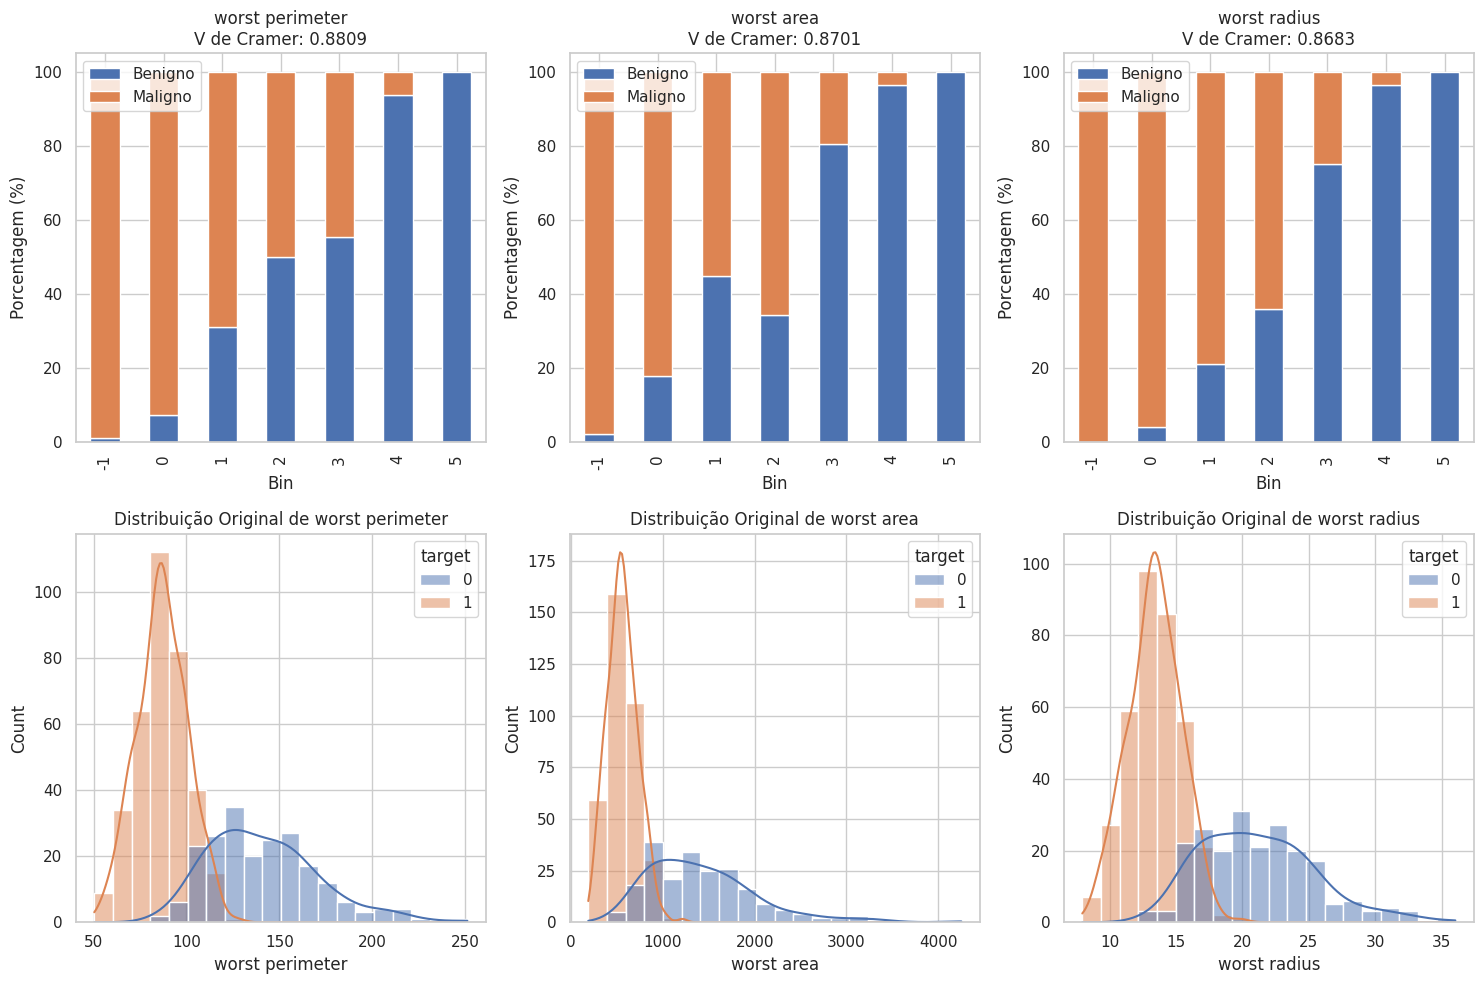

,V de Cramer,Classe 0 (%),Classe 1 (%)
worst perimeter,0.880889,"{-1: 0.9433962264150944, 0: 2.8301886792452833...","{-1: 64.70588235294117, 0: 21.568627450980394,..."
worst area,0.870102,"{-1: 2.8301886792452833, 0: 2.358490566037736,...","{-1: 79.83193277310924, 0: 6.442577030812324, ..."
worst radius,0.868252,"{0: 2.8301886792452833, 1: 3.7735849056603774,...","{-1: 36.69467787114846, 0: 42.296918767507, 1:..."
worst concave points,0.861292,"{-1: 1.8867924528301887, 0: 2.8301886792452833...","{-1: 65.54621848739495, 0: 19.047619047619047,..."
mean concave points,0.850294,"{0: 0.9433962264150944, 1: 5.660377358490567, ...","{-1: 39.49579831932773, 0: 20.168067226890756,..."
mean perimeter,0.817215,"{-1: 5.188679245283019, 0: 5.660377358490567, ...","{-1: 72.82913165266106, 0: 13.725490196078432,..."
mean area,0.806743,"{-1: 2.8301886792452833, 0: 3.30188679245283, ...","{-1: 55.74229691876751, 0: 15.126050420168067,..."
mean radius,0.800884,"{-1: 1.4150943396226416, 0: 4.716981132075472,...","{-1: 41.17647058823529, 0: 29.411764705882355,..."
mean concavity,0.796683,"{0: 7.547169811320755, 1: 7.547169811320755, 2...","{-1: 30.81232492997199, 0: 52.66106442577031, ..."
area error,0.781423,"{0: 1.4150943396226416, 1: 4.716981132075472, ...","{-1: 19.327731092436977, 0: 24.649859943977592..."


In [12]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

def hybrid_discretization(df, target='target', n_bins=5, transform_method='logarithmic', 
                         strategy='quantile', supervised_refinement=True, plot_results=True):
    """
    Realiza discretização híbrida combinando transformação robusta com discretização supervisionada.
    
    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame de entrada com as variáveis contínuas originais
    target : str
        Nome da coluna alvo (diagnóstico)
    n_bins : int
        Número inicial de intervalos para discretização
    transform_method : str
        Método de transformação para lidar com outliers: 'logarithmic', 'rank', ou 'none'
    strategy : str
        Estratégia inicial para discretização ('uniform', 'quantile', ou 'kmeans')
    supervised_refinement : bool
        Se True, refina os bins usando árvores de decisão para maximizar separação entre classes
    plot_results : bool
        Se True, gera visualizações das discretizações mais importantes
        
    Retorna:
    --------
    df_processed : pandas.DataFrame
        DataFrame com as variáveis discretizadas e o diagnóstico
    feature_importance : pandas.DataFrame
        Métricas de importância de cada variável após discretização
    """
    # Pega as colunas de atributos (menos o target)
    feature_cols = [col for col in df.columns if col != target]
    X = df[feature_cols].values
    y = df[target].values
    
    # Aplica transformação robusta para lidar com outliers
    X_transformed = np.zeros_like(X)
    
    for i in range(X.shape[1]):
        if transform_method == 'logarithmic':
            # Adiciona um pequeno valor para lidar com zeros
            min_val = np.min(X[:, i])
            if min_val <= 0:
                X_transformed[:, i] = np.log(X[:, i] - min_val + 1e-3)
            else:
                X_transformed[:, i] = np.log(X[:, i])
        elif transform_method == 'rank':
            # Transformação por ranqueamento (menos sensível a outliers)
            X_transformed[:, i] = stats.rankdata(X[:, i])/len(X[:, i])
        else:  # 'none'
            X_transformed[:, i] = X[:, i]
    
    # Cria o discretizador inicial
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    
    # Ajusta e transforma
    X_disc = discretizer.fit_transform(X_transformed)
    
    # Se refinamento supervisionado estiver ativado
    if supervised_refinement:
        # Para cada variável, tenta refinar os bins para maximizar a separação entre classes
        for i, col in enumerate(feature_cols):
            # Cria uma árvore de decisão com profundidade limitada para encontrar os pontos de corte ótimos
            dt = DecisionTreeClassifier(max_depth=min(3, n_bins-1), min_samples_leaf=max(10, int(0.05*len(y))))
            dt.fit(X_transformed[:, i].reshape(-1, 1), y)
            
            # Se a árvore encontrou partições úteis, usamos esses pontos para discretização
            if dt.tree_.node_count > 1:  # Se a árvore não for apenas o nó raiz
                # Extraímos os limiares da árvore
                thresholds = []
                for node_id in range(dt.tree_.node_count):
                    if dt.tree_.children_left[node_id] != -1:  # se não for folha
                        thresholds.append(dt.tree_.threshold[node_id])
                
                if thresholds:
                    # Ordenamos e removemos duplicatas
                    thresholds = sorted(list(set(thresholds)))
                    
                    # Criamos bins personalizados baseados nos limiares da árvore
                    bins = [-np.inf] + thresholds + [np.inf]
                    X_disc[:, i] = np.digitize(X_transformed[:, i], bins[1:-1]) - 1
    
    # Cria um novo dataframe com as colunas discretizadas
    df_processed = pd.DataFrame()
    
    # Adiciona colunas discretizadas
    for i, col in enumerate(feature_cols):
        df_processed[f"{col}_disc"] = X_disc[:, i].astype(int)
    
    # Adiciona coluna de diagnóstico
    df_processed['diagnosis'] = y
    
    # Estatísticas e avaliação da discretização
    feature_importance = pd.DataFrame(index=feature_cols)
    cramers_v_values = []
    entropy_reduction = []
    
    # Calcula estatísticas para cada variável
    for i, col in enumerate(feature_cols):
        disc_col = f"{col}_disc"
        
        # Distribuição dos bins
        bin_counts = df_processed[disc_col].value_counts(normalize=True).sort_index() * 100
        
        # Calcula V de Cramer (força da associação com o target)
        crosstab = pd.crosstab(df_processed[disc_col], df_processed['diagnosis'])
        chi2 = stats.chi2_contingency(crosstab)[0]
        n = crosstab.sum().sum()
        phi2 = chi2/n
        r, k = crosstab.shape
        cramers_v = np.sqrt(phi2/min(k-1, r-1))
        cramers_v_values.append((col, cramers_v))
        
        # Armazena V de Cramer
        feature_importance.loc[col, 'V de Cramer'] = cramers_v
        
        # Distribuição dos bins por classe
        for target_val in df_processed['diagnosis'].unique():
            class_prop = df_processed[df_processed['diagnosis'] == target_val][disc_col].value_counts(normalize=True).sort_index() * 100
            feature_importance.loc[col, f'Classe {target_val} (%)'] = str(class_prop.to_dict())
    
    # Ordena variáveis por importância
    feature_importance = feature_importance.sort_values('V de Cramer', ascending=False)
    
    # Exibe resultados
    print(f"\nDiscretização híbrida concluída: {len(feature_cols)} variáveis processadas usando abordagem '{transform_method}+{strategy}'")
    if supervised_refinement:
        print("Refinamento supervisionado aplicado para maximizar a separação entre as classes")
    
    # Top 5 variáveis com maior associação com o diagnóstico
    # print("\nTop 5 variáveis com maior poder preditivo (V de Cramer):")
    # for col in feature_importance.index[:5]:
    #    print(f"  {col}: {feature_importance.loc[col, 'V de Cramer']:.4f}")
    
    # Visualizações se solicitado
    if plot_results:
        plt.figure(figsize=(15, 10))
        
        # Plot top 3 variáveis mais importantes
        for i, col in enumerate(feature_importance.index[:3]):
            disc_col = f"{col}_disc"
            
            plt.subplot(2, 3, i+1)
            crosstab_pct = pd.crosstab(df_processed[disc_col], df_processed['diagnosis'], 
                                       normalize='index') * 100
            crosstab_pct.plot(kind='bar', stacked=True, ax=plt.gca())
            plt.title(f"{col}\nV de Cramer: {feature_importance.loc[col, 'V de Cramer']:.4f}")
            plt.xlabel('Bin')
            plt.ylabel('Porcentagem (%)')
            plt.legend(['Benigno', 'Maligno'])
            
            # Também mostra a distribuição original da variável
            plt.subplot(2, 3, i+4)
            sns.histplot(data=df, x=col, hue=target, bins=20, kde=True)
            plt.title(f"Distribuição Original de {col}")
        
        plt.tight_layout()
        plt.show()
        
       # # Heatmap de correlação entre as variáveis discretizadas
       # plt.figure(figsize=(12, 10))
       # top_features = feature_importance.index[:10].tolist()
       # top_disc_cols = [f"{col}_disc" for col in top_features]
       # corr_matrix = df_processed[top_disc_cols].corr()
        
       # mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
       # sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
       # plt.title("Correlação entre as Top 10 Variáveis Discretizadas")
       # plt.tight_layout()
       # plt.show()
    
    return df_processed, feature_importance

# Aplica a discretização híbrida
df_disc, feature_importance = hybrid_discretization(
    df_full, 
    target='target', 
    n_bins=5, 
    transform_method='logarithmic',  # 'logarithmic', 'rank', ou 'none'
    strategy='quantile',             # 'uniform', 'quantile', ou 'kmeans'
    supervised_refinement=True,      # Refinamento supervisionado
    plot_results=True                # Gerar visualizações
)

# Mostra as 10 variáveis mais importantes
display(feature_importance.head(10))


## 3. Análise Exploratória dos Dados

**Objetivos da Análise Exploratória**

* **Compreender a distribuição** das variáveis discretizadas no dataset;
* **Avaliar o balanceamento** das classes da variável alvo (benigno vs. maligno);
* **Explorar as relações** entre variáveis explicativas e o diagnóstico de câncer;
* **Identificar correlações** relevantes que possam influenciar a estrutura da rede.




In [13]:
df_full

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [14]:
df_disc

,mean radius_disc,mean texture_disc,mean perimeter_disc,mean area_disc,mean smoothness_disc,mean compactness_disc,mean concavity_disc,mean concave points_disc,mean symmetry_disc,mean fractal dimension_disc,radius error_disc,texture error_disc,perimeter error_disc,area error_disc,smoothness error_disc,compactness error_disc,concavity error_disc,concave points error_disc,symmetry error_disc,fractal dimension error_disc,worst radius_disc,worst texture_disc,worst perimeter_disc,worst area_disc,worst smoothness_disc,worst compactness_disc,worst concavity_disc,worst concave points_disc,worst symmetry_disc,worst fractal dimension_disc,diagnosis
0,4,-1,5,5,6,6,5,6,6,4,6,1,6,6,2,5,6,5,3,4,5,0,5,5,5,6,5,5,4,5,0
1,5,1,5,5,2,0,1,4,3,2,4,0,4,5,2,0,2,4,1,3,5,2,5,5,1,1,1,5,0,2,0
2,5,3,5,5,5,5,5,6,4,2,5,0,5,6,2,5,6,5,2,3,5,3,5,5,4,5,4,5,3,2,0
3,-1,3,-1,-1,6,6,5,6,6,4,4,1,4,2,2,5,6,5,4,5,0,3,0,-1,6,6,5,5,4,5,0
4,5,-1,5,5,4,4,5,6,3,2,5,0,6,6,3,4,6,5,1,4,5,0,5,5,3,2,4,4,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,5,4,5,5,5,3,5,6,3,1,6,1,6,6,2,4,6,6,-1,3,5,3,5,5,3,2,4,5,-1,-1,0
565,5,5,5,5,3,3,4,6,3,0,5,3,6,6,2,4,6,5,2,1,5,6,5,5,1,1,3,4,0,-1,0
566,3,5,3,3,1,3,1,3,1,1,3,1,4,4,2,5,6,5,0,3,4,6,4,4,1,3,3,2,-1,0,0
567,5,5,5,5,6,6,5,6,6,3,5,1,6,6,2,5,6,5,2,4,5,6,5,5,6,6,5,5,4,5,0


### 3.1 Distribuição das Variáveis  
- Vamos criar histogramas para visualizar a distribuição das variáveis discretizadas e entender como os dados estão distribuídos nas categorias **low**, **medium** e **high**.


Estatísticas para mean radius_disc:
Bin -1: 26.36%
Bin 0: 20.21%
Bin 1: 8.61%
Bin 2: 14.59%
Bin 3: 9.49%
Bin 4: 4.92%
Bin 5: 15.82%
------------------------------

Estatísticas para mean texture_disc:
Bin -1: 16.17%
Bin 0: 10.72%
Bin 1: 18.98%
Bin 2: 9.67%
Bin 3: 18.98%
Bin 4: 19.68%
Bin 5: 5.80%
------------------------------

Estatísticas para mean perimeter_disc:
Bin -1: 47.63%
Bin 0: 10.72%
Bin 1: 5.80%
Bin 2: 6.33%
Bin 3: 7.38%
Bin 4: 4.92%
Bin 5: 17.22%
------------------------------

Estatísticas para mean area_disc:
Bin -1: 36.03%
Bin 0: 10.72%
Bin 1: 8.08%
Bin 2: 14.94%
Bin 3: 9.14%
Bin 4: 4.92%
Bin 5: 16.17%
------------------------------

Estatísticas para mean smoothness_disc:
Bin -1: 8.44%
Bin 0: 5.98%
Bin 1: 6.68%
Bin 2: 12.65%
Bin 3: 27.94%
Bin 4: 20.04%
Bin 5: 10.02%
Bin 6: 8.26%
------------------------------

Estatísticas para mean compactness_disc:
Bin -1: 16.52%
Bin 0: 26.54%
Bin 1: 5.45%
Bin 2: 7.03%
Bin 3: 14.76%
Bin 4: 13.71%
Bin 5: 7.38%
Bin 6: 8.61%
----------

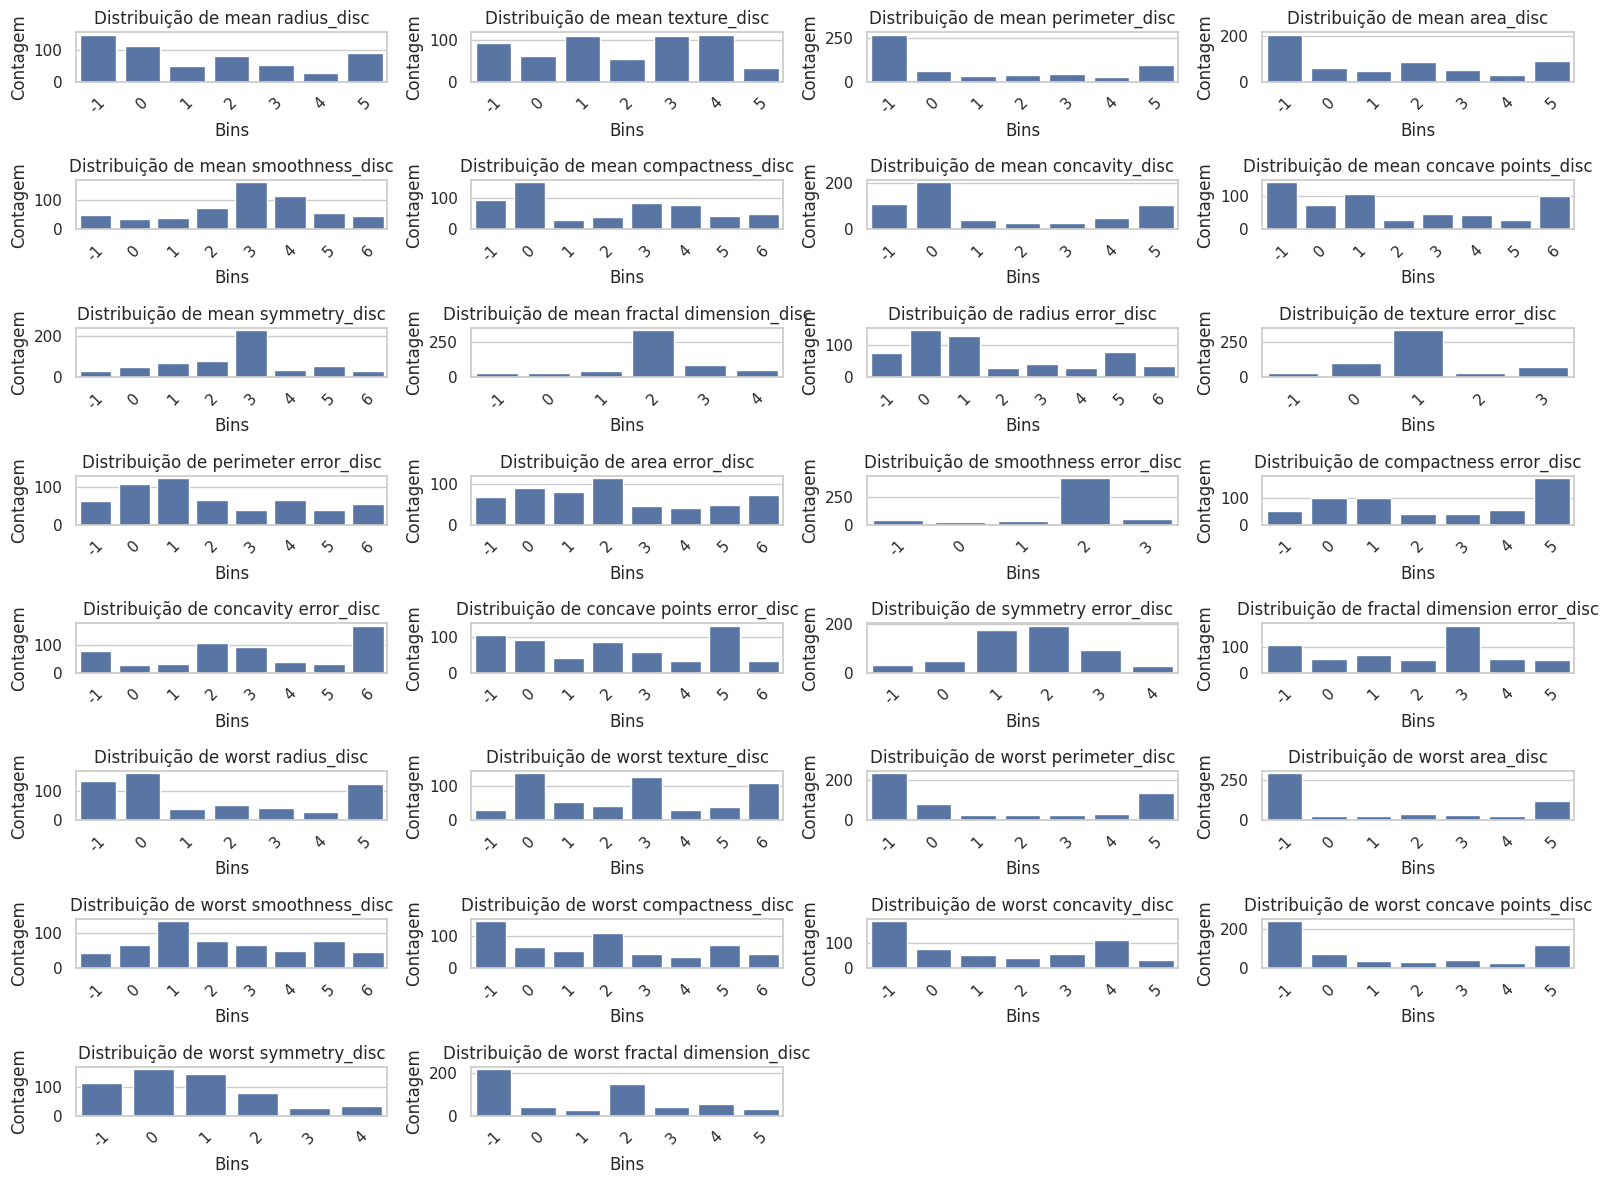

In [15]:
# Configurações de visualização
plt.style.use('ggplot')
sns.set(style="whitegrid")

def plot_multiple_distributions(df, columns_to_plot=None, cols_per_row=4, figsize=(16, 12)):
    """
    Plota a distribuição de múltiplas variáveis discretizadas em um grid de subplots.

    Parâmetros:
    - df: DataFrame contendo os dados
    - columns_to_plot: Lista de colunas para plotar (se None, usa todas exceto 'diagnosis' e 'target')
    - cols_per_row: Número de gráficos por linha
    - figsize: Tamanho da figura completa
    """
    if columns_to_plot is None:
        # Exclui colunas que não são variáveis discretizadas
        columns_to_plot = [col for col in df.columns if col not in ['diagnosis', 'target']]

    # Calcula o número de linhas necessárias
    n_cols = len(columns_to_plot)
    n_rows = math.ceil(n_cols / cols_per_row)

    # Cria a figura e os subplots
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize)
    axes = axes.flatten()  # Transforma em array 1D para facilitar indexação

    # Para cada coluna, cria um countplot em um subplot
    for i, col in enumerate(columns_to_plot):
        if i < len(axes):  # Garante que não ultrapasse o número de subplots
            ax = axes[i]

            # Cria o countplot
            sns.countplot(x=col, data=df, ax=ax)

            # Configura o título e rótulos
            ax.set_title(f'Distribuição de {col}')
            ax.set_xlabel('Bins')
            ax.set_ylabel('Contagem')
            ax.tick_params(axis='x', rotation=45)

            # Exibe estatísticas no console
            value_counts = df[col].value_counts(normalize=True).sort_index() * 100
            print(f"\nEstatísticas para {col}:")
            for bin_value, percentage in value_counts.items():
                print(f"Bin {bin_value}: {percentage:.2f}%")
            print("-" * 30)

    # Oculta subplots vazios
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Ajusta o layout
    plt.tight_layout()
    plt.show()

# Executar com todas as variáveis (exceto diagnosis e target)
plot_multiple_distributions(df_disc)

# para visualizar apenas algumas variáveis específicas:
# selected_columns = ['mean radius', 'mean texture', 'worst radius', 'worst texture']
# plot_multiple_distributions(df_disc, columns_to_plot=selected_columns, cols_per_row=2)

## 3.2 Estatísticas Descritivas

In [16]:
def analyze_original_variables(df, target_col=None):
    """
    Analisa estatísticas descritivas das variáveis originais (não binarizadas).
    
    Parâmetros:
    df (pandas.DataFrame): DataFrame de entrada
    target_col (str ou None): Nome da coluna target, se presente. Essa coluna será excluída da análise.
    
    Retorna:
    pandas.DataFrame: Estatísticas descritivas com skewness e curtose
    """
    # Seleciona colunas numéricas originais (sem 'bin' no nome)
    original_features = [
        col for col in df.columns 
        if 'bin' not in col and (col != target_col if target_col else True)
    ]

    # Estatísticas descritivas
    desc_stats_orig = df[original_features].describe().T

    # Adiciona skewness e curtose
    desc_stats_orig['skewness'] = df[original_features].skew()
    desc_stats_orig['kurtosis'] = df[original_features].kurtosis()

    return desc_stats_orig


In [17]:
desc_stats_orig = analyze_original_variables(df_data)
print("Estatísticas descritivas das variáveis originais:")
print(desc_stats_orig)

Estatísticas descritivas das variáveis originais:
                         count        mean         std         min         25%         50%  \
mean radius              569.0   14.127292    3.524049    6.981000   11.700000   13.370000   
mean texture             569.0   19.289649    4.301036    9.710000   16.170000   18.840000   
mean perimeter           569.0   91.969033   24.298981   43.790000   75.170000   86.240000   
mean area                569.0  654.889104  351.914129  143.500000  420.300000  551.100000   
mean smoothness          569.0    0.096360    0.014064    0.052630    0.086370    0.095870   
mean compactness         569.0    0.104341    0.052813    0.019380    0.064920    0.092630   
mean concavity           569.0    0.088799    0.079720    0.000000    0.029560    0.061540   
mean concave points      569.0    0.048919    0.038803    0.000000    0.020310    0.033500   
mean symmetry            569.0    0.181162    0.027414    0.106000    0.161900    0.179200   
mean fract

In [18]:
# Exibir estatísticas descritivas do DataFrame processado
desc_stats_pro = analyze_original_variables(df_disc, target_col='target')
print("Estatísticas descritivas das variáveis discretizadas:")
print(desc_stats_pro)

Estatísticas descritivas das variáveis discretizadas:
                              count      mean       std  min  25%  50%  75%  max  skewness  \
mean radius_disc              569.0  1.386643  2.148099 -1.0 -1.0  1.0  3.0  5.0  0.471104   
mean texture_disc             569.0  1.868190  1.887279 -1.0  0.0  2.0  4.0  5.0 -0.100846   
mean perimeter_disc           569.0  0.987698  2.362006 -1.0 -1.0  0.0  3.0  5.0  0.708966   
mean area_disc                569.0  1.298770  2.238904 -1.0 -1.0  1.0  3.0  5.0  0.452888   
mean smoothness_disc          569.0  2.871705  1.901461 -1.0  2.0  3.0  4.0  6.0 -0.445979   
mean compactness_disc         569.0  1.906854  2.311203 -1.0  0.0  2.0  4.0  6.0  0.293272   
mean concavity_disc           569.0  1.411248  2.230458 -1.0  0.0  0.0  4.0  5.0  0.593598   
mean concave points_disc      569.0  1.905097  2.571812 -1.0  0.0  1.0  4.0  6.0  0.434576   
mean symmetry_disc            569.0  2.546573  1.718282 -1.0  1.0  3.0  3.0  6.0 -0.133641   
mean f

### 3.2.1 Comparação de Distribuições

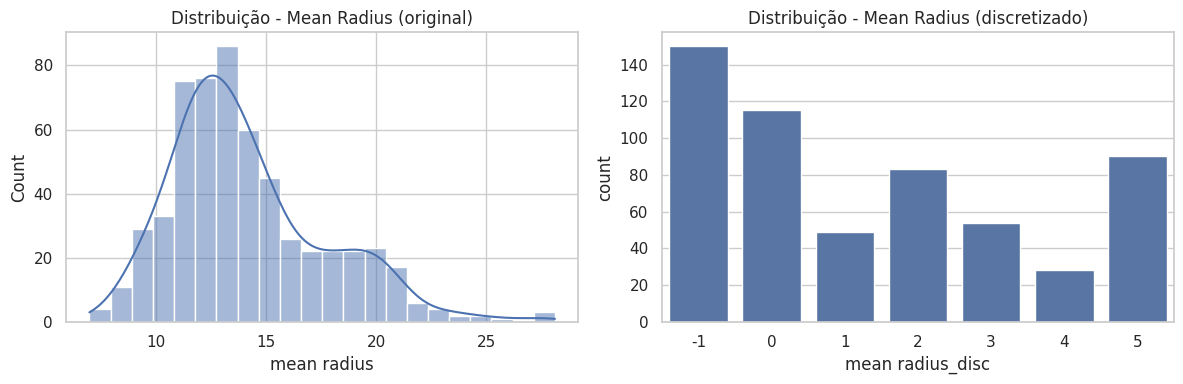

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_data['mean radius'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição - Mean Radius (original)')
sns.countplot(x='mean radius_disc', data=df_disc, ax=axes[1])
axes[1].set_title('Distribuição - Mean Radius (discretizado)')
plt.tight_layout()
plt.show()

#### Variáveis discretizadas mais assimétricas
As variáveis discretizadas com maior assimetria (skewness) indicam que a distribuição dos dados não é simétrica, o que pode afetar a interpretação e a inferência da rede. Variáveis com alta assimetria podem indicar que a maioria dos casos se concentra em uma das extremidades da distribuição, o que pode ser relevante para o diagnóstico.



In [20]:
desc_stats_pro.sort_values(by='skewness', ascending=False).head(5)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
mean perimeter_disc,569.0,0.987698,2.362006,-1.0,-1.0,0.0,3.0,5.0,0.708966,-1.145632
worst symmetry_disc,569.0,0.745167,1.392920,-1.0,0.0,1.0,2.0,4.0,0.693569,-0.134371
radius error_disc,569.0,1.680141,2.213032,-1.0,0.0,1.0,4.0,6.0,0.639324,-0.950707
worst area_disc,569.0,1.105448,2.490713,-1.0,-1.0,-1.0,4.0,5.0,0.597630,-1.370492
mean concavity_disc,569.0,1.411248,2.230458,-1.0,0.0,0.0,4.0,5.0,0.593598,-1.262859


### 3.3 Relações com a Classe Alvo  
- Examinamos o comportamento de cada variável discretizada em relação à classe alvo, identificando padrões e tendências que possam auxiliar no diagnóstico.

In [21]:
def analyze_variables_relationship_with_target(df, target_col=None, n_vars=10, figsize=(18, 15)):
    """
    Examina a relação entre variáveis discretizadas e a classe alvo.
    
    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo as variáveis discretizadas e a coluna alvo
    target_col : str
        Nome da coluna alvo (obrigatório)
    n_vars : int
        Número de variáveis principais a serem exibidas com base no V de Cramer
    figsize : tuple
        Tamanho da figura para o gráfico
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame com valores de V de Cramer e estatísticas de distribuição de classe para cada variável
    """
    if target_col is None or target_col not in df.columns:
        raise ValueError("A coluna alvo (target_col) deve ser informada e estar presente no DataFrame.")
    
    results = []
    feature_cols = [col for col in df.columns if col != target_col]
    
    for col in feature_cols:
        contingency = pd.crosstab(df[col], df[target_col])
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        n = contingency.sum().sum()
        phi2 = chi2 / n
        r, k = contingency.shape
        cramers_v = np.sqrt(phi2 / min((k-1), (r-1)))

        class_dist = {}
        for bin_val in sorted(df[col].unique()):
            bin_data = df[df[col] == bin_val]
            if len(bin_data) > 0:
                for target_val in sorted(df[target_col].unique()):
                    key = f'Bin {bin_val} Class {target_val} %'
                    count = len(bin_data[bin_data[target_col] == target_val])
                    pct = count / len(bin_data) * 100
                    class_dist[key] = pct
        
        results.append({
            'Variable': col,
            'Cramer\'s V': cramers_v,
            'p-value': p,
            **class_dist
        })
    
    results_df = pd.DataFrame(results).sort_values('Cramer\'s V', ascending=False)
    
    plt.figure(figsize=figsize)
    top_vars = results_df['Variable'].head(n_vars).tolist()
    
    for i, var in enumerate(top_vars):
        plt.subplot(int(np.ceil(n_vars/2)), 2, i+1)
        ct = pd.crosstab(df[var], df[target_col], normalize='index') * 100
        ct.plot(kind='bar', stacked=True, ax=plt.gca(), 
                color=['#66c2a5', '#fc8d62'], width=0.8)
        
        v_value = results_df.loc[results_df['Variable'] == var, 'Cramer\'s V'].values[0]
        plt.title(f'{var} vs. {target_col} (Cramer\'s V: {v_value:.4f})', fontsize=12)
        plt.xlabel('Valor do Bin')
        plt.ylabel('Porcentagem (%)')
        plt.legend(['Benigno (0)', 'Maligno (1)'])
        plt.grid(axis='y', alpha=0.3)

        for bar in plt.gca().patches:
            height = bar.get_height()
            if height > 5:
                plt.gca().text(
                    bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + height/2,
                    f'{height:.1f}%',
                    ha='center', va='center',
                    color='white', fontweight='bold'
                )
    
    plt.tight_layout()
    plt.show()
    
    return results_df

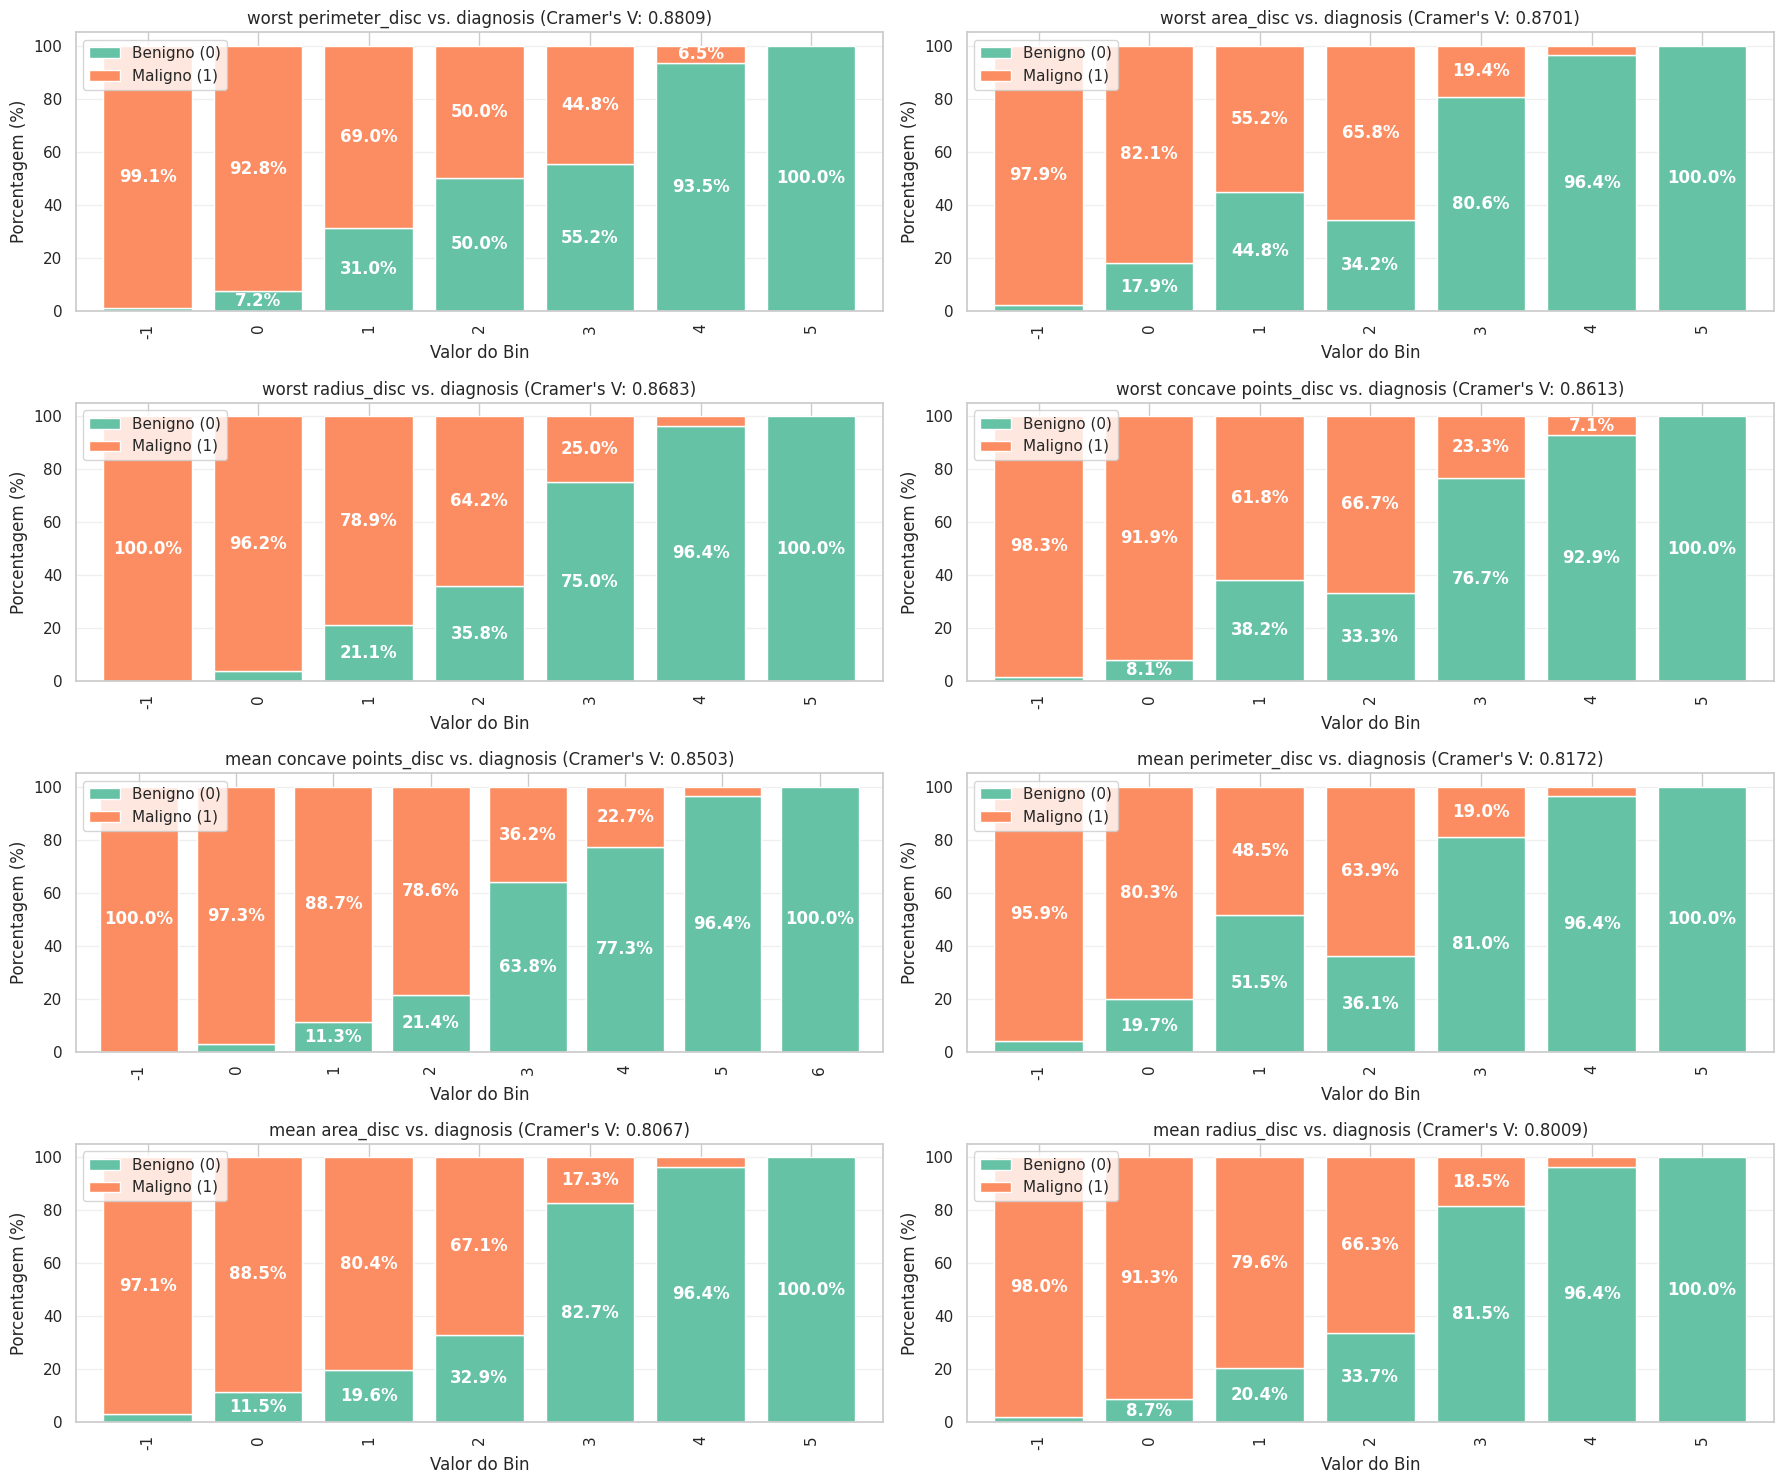

,Variable,Cramer's V,p-value,Bin -1 Class 0 %,Bin -1 Class 1 %,Bin 0 Class 0 %,Bin 0 Class 1 %,Bin 1 Class 0 %,Bin 1 Class 1 %,Bin 2 Class 0 %,Bin 2 Class 1 %,Bin 3 Class 0 %,Bin 3 Class 1 %,Bin 4 Class 0 %,Bin 4 Class 1 %,Bin 5 Class 0 %,Bin 5 Class 1 %,Bin 6 Class 0 %,Bin 6 Class 1 %
22,worst perimeter_disc,0.880889,3.273285e-92,0.858369,99.141631,7.228916,92.771084,31.034483,68.965517,50.000000,50.000000,55.172414,44.827586,93.548387,6.451613,100.000000,0.000000,NaN,NaN
23,worst area_disc,0.870102,6.719895e-90,2.061856,97.938144,17.857143,82.142857,44.827586,55.172414,34.210526,65.789474,80.555556,19.444444,96.428571,3.571429,100.000000,0.000000,NaN,NaN
20,worst radius_disc,0.868252,1.663696e-89,0.000000,100.000000,3.821656,96.178344,21.052632,78.947368,35.849057,64.150943,75.000000,25.000000,96.428571,3.571429,100.000000,0.000000,NaN,NaN
27,worst concave points_disc,0.861292,4.948520e-88,1.680672,98.319328,8.108108,91.891892,38.235294,61.764706,33.333333,66.666667,76.744186,23.255814,92.857143,7.142857,100.000000,0.000000,NaN,NaN
7,mean concave points_disc,0.850294,8.613253e-85,0.000000,100.000000,2.702703,97.297297,11.320755,88.679245,21.428571,78.571429,63.829787,36.170213,77.272727,22.727273,96.428571,3.571429,100.000000,0.000000
2,mean perimeter_disc,0.817215,5.556933e-79,4.059041,95.940959,19.672131,80.327869,51.515152,48.484848,36.111111,63.888889,80.952381,19.047619,96.428571,3.571429,100.000000,0.000000,NaN,NaN
3,mean area_disc,0.806743,6.664236e-77,2.926829,97.073171,11.475410,88.524590,19.565217,80.434783,32.941176,67.058824,82.692308,17.307692,96.428571,3.571429,100.000000,0.000000,NaN,NaN
0,mean radius_disc,0.800884,9.441672e-76,2.000000,98.000000,8.695652,91.304348,20.408163,79.591837,33.734940,66.265060,81.481481,18.518519,96.428571,3.571429,100.000000,0.000000,NaN,NaN
6,mean concavity_disc,0.796683,6.239452e-75,0.000000,100.000000,7.843137,92.156863,38.095238,61.904762,57.142857,42.857143,70.000000,30.000000,86.000000,14.000000,95.238095,4.761905,NaN,NaN
13,area error_disc,0.781423,4.344198e-71,0.000000,100.000000,3.296703,96.703297,12.195122,87.804878,19.827586,80.172414,53.191489,46.808511,73.170732,26.829268,96.000000,4.000000,100.000000,0.000000


In [22]:
analyze_variables_relationship_with_target(df_disc, target_col='diagnosis', n_vars=8)


### 3.3 Análise de Correlação  
- Analisamos uma matriz de correlação para dados discretizados, utilizando métodos apropriados (como a **correlação de Spearman**) para identificar dependências entre atributos que influenciam o diagnóstico.



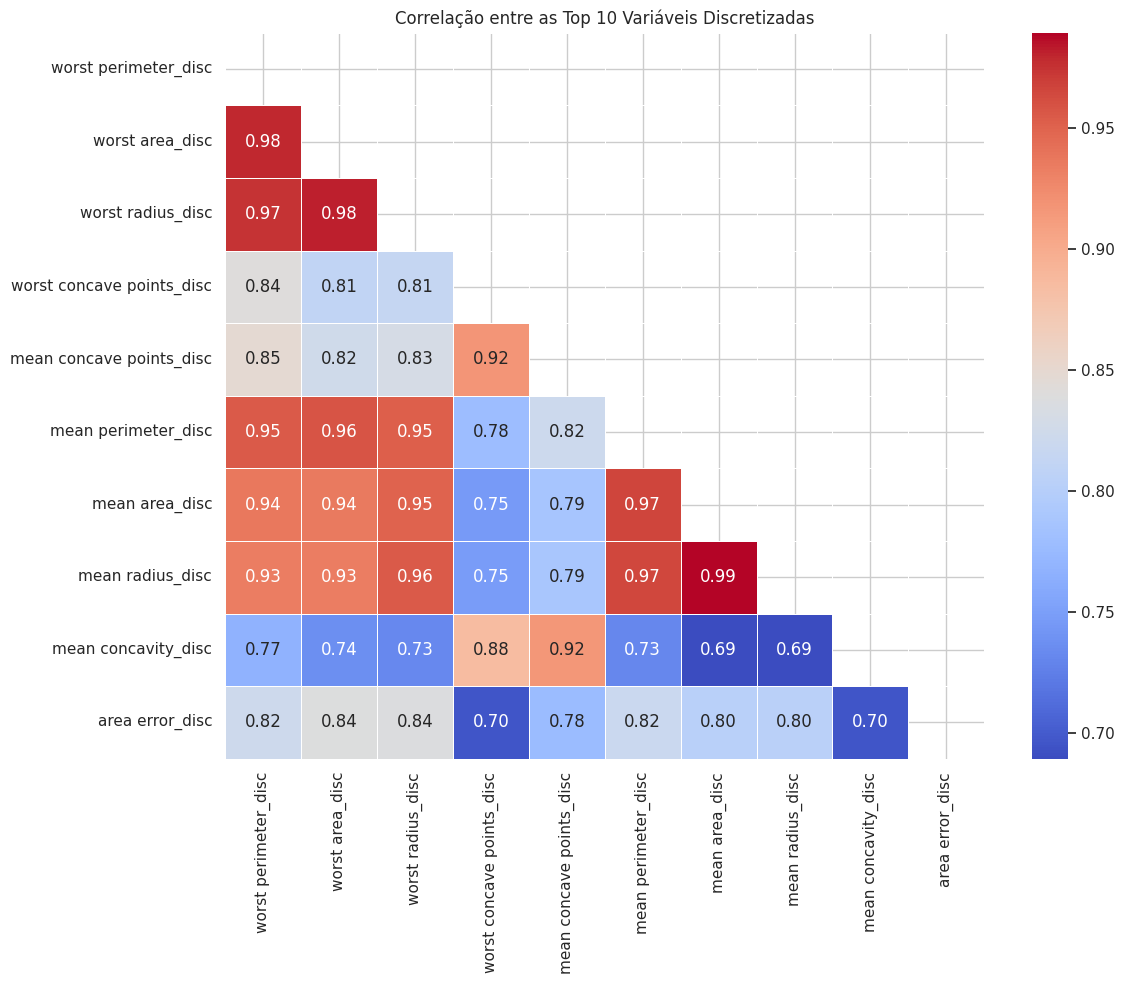

In [23]:
# Seleciona as 10 variáveis discretizadas mais importantes
top_features = feature_importance.index[:10].tolist()
top_disc_cols = [f"{col}_disc" for col in top_features]

# Calcula matriz de correlação
corr_matrix = df_disc[top_disc_cols].corr()

# Cria máscara para ocultar metade superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Exibe o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlação entre as Top 10 Variáveis Discretizadas")
plt.tight_layout()
plt.show()

### 3.4 Análise de Componentes (PCA)  
- Aplicamos **PCA** para detectar padrões de variabilidade e visualizar como as amostras se agrupam no espaço de componentes principais, mesmo após a discretização.



In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_and_plot(df, target_col='diagnosis', n_components=2, title='PCA - Espaço de Componentes Principais'):
    """
    Aplica PCA em um DataFrame discretizado e visualiza o agrupamento das amostras.
    
    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo as variáveis discretizadas e a coluna alvo.
    target_col : str
        Nome da coluna de classe alvo.
    n_components : int
        Número de componentes principais a calcular (default=2).
    title : str
        Título do gráfico gerado.
        
    Retorna:
    --------
    pd.DataFrame
        DataFrame com os componentes principais e a classe alvo.
    """
    if target_col not in df.columns:
        raise ValueError("A coluna alvo especificada não está presente no DataFrame.")
    
    # Selecionar variáveis discretizadas (excluindo a coluna alvo)
    feature_cols = [col for col in df.columns if col != target_col]

    # Standardizar os dados
    X = df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    # Aplicar PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    # Construir DataFrame dos componentes principais
    pca_df = pd.DataFrame(data=principal_components,
                          columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df[target_col] = df[target_col].values

    # Visualização
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=pca_df, 
        x='PC1', y='PC2', 
        hue=target_col, 
        palette='Set1',
        alpha=0.8,
        edgecolor='k'
    )
    plt.title(title, fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% da variância)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% da variância)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Classe')
    plt.tight_layout()
    plt.show()
    
    return pca_df


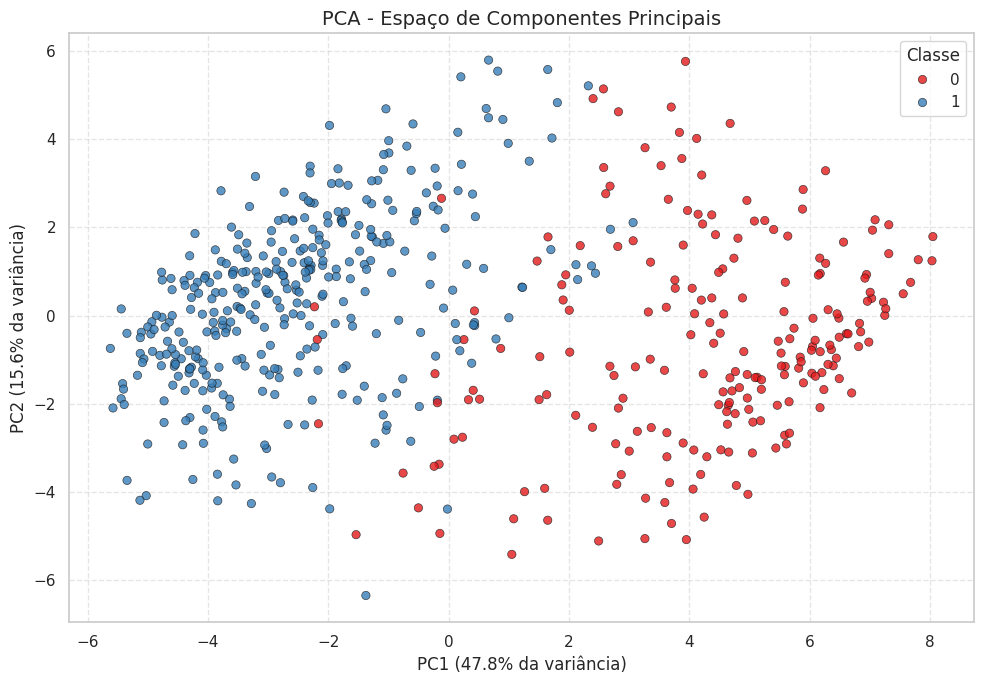

In [25]:
# Aplica PCA aos dados discretizados e visualiza
pca_df = perform_pca_and_plot(df_disc, target_col='diagnosis')

## 4. Interpretação (Análise mesmo)

### 4.1 Medidas de Associação e Qualidade

##### Coeficiente V de Cramer  
O V de Cramer é uma medida de associação entre duas variáveis categóricas, derivada do teste qui‑quadrado de Pearson. No contexto deste projeto, ele quantifica a força da relação entre cada variável discretizada e o diagnóstico, sendo fundamental para avaliar a qualidade da discretização.

**Fórmula**  
$$V = \sqrt{\frac{\chi^2/n}{\min(k-1, r-1)}}$$

- \(\chi^2\): estatística qui‑quadrado de Pearson  
- \(n\): total de observações  
- \(k\): número de colunas na tabela de contingência  
- \(r\): número de linhas na tabela de contingência  

**Interpretação**  
O valor de \(V\) varia entre 0 e 1:
- 0.0–0.1: Associação negligenciável  
- 0.1–0.3: Associação fraca  
- 0.3–0.5: Associação moderada  
- 0.5–0.8: Associação forte  
- 0.8–1.0: Associação muito forte  


### 4.1 PCA

A Análise de Componentes Principais (PCA) aplicada aos dados discretizados revelou uma separação clara entre as classes no espaço formado pelos dois primeiros componentes principais, que juntos explicam mais de 63% da variância total. A visualização evidencia dois agrupamentos distintos, indicando que a variabilidade capturada pelas componentes principais está fortemente relacionada à variável de diagnóstico. Este comportamento sugere que, mesmo após a discretização das variáveis contínuas, a estrutura de variância do conjunto de dados preserva padrões diagnósticos relevantes, o que reforça a eficácia da discretização e da seleção das variáveis mais informativas.

### 4.2 Padrões de Correlação Entre Variáveis Discretizadas

1. **Cluster de Tamanho Tumoral**  
   - `worst perimeter`, `worst area`, `worst radius` têm correlação 0.97–0.98, indicando redundância informacional.

2. **Características de Concavidade**  
   - `worst concave points` ↔ `mean concave points`: correlação ~0.92, sinalizando consistência entre média e extremos.

3. **Variáveis de Erro**  
   - `area error` mostra correlações de 0.70–0.84 com outras métricas, fornecendo informação complementar.

### 4.3 Seleção Estratégica de Variáveis para a Rede Bayesiana
Complementarmente, o heatmap de correlação destaca grupos de variáveis altamente correlacionadas, como as associadas ao tamanho tumoral (worst perimeter, worst area, worst radius) e às características de concavidade (worst concave points, mean concave points). A alta redundância informacional dentro desses grupos justifica a escolha de apenas uma variável representativa de cada cluster, reduzindo a complexidade do modelo sem perda significativa de informação. A inclusão de variáveis como area error, com correlação moderada e conteúdo informativo complementar, também se mostra estratégica. Assim, os padrões de agrupamento observados na PCA e os blocos de alta correlação no heatmap sustentam a seleção racional de um subconjunto de quatro variáveis para compor uma Rede Bayesiana compacta e interpretável, capaz de capturar os principais determinantes do diagnóstico.

Portanto, para construir uma rede bayesiana enxuta e potente, selecionamos quatro variáveis discretizadas que oferecem alto poder discriminativo e reduzida redundância. Primeiro, **worst\_perimeter\_disc** (V de Cramer = 0,881) sintetiza o cluster de tamanho tumoral e, devido à sua correlação quase perfeita com **worst\_area** e **worst\_radius**, torna desnecessária a inclusão destas. Em seguida, **worst\_concave\_points\_disc** (V = 0,861) captura fielmente as características de concavidade, separando casos malignos e benignos em faixas quase puras e dispensando **mean\_concave\_points** por forte correlação. Como complemento, **mean\_concavity\_disc** (V = 0,797) acrescenta informação sobre morfologia que não se sobrepõe totalmente às demais, e **area\_error\_disc** (V = 0,781) reflete variações nos padrões celulares que enriquecem o diagnóstico. Com esse conjunto de quatro variáveis, reduzimos de 30 para 4 o número de nós na rede, garantindo Tabelas de Probabilidade Condicional mais robustas e uma interpretação clínica direta. Mas vamos ver o resultao da discretização antes de mudar o dataframe.


## Variáveis Selecionadas e Justificativa

| Variável                     | V de Cramer | Justificativa                                                                                      |
|-----------------------------|-------------|-----------------------------------------------------------------------------------------------------|
| `worst_perimeter_disc`      | 0.881       | Representa todo o cluster de tamanho tumoral, dispensando `worst_area` e `worst_radius`            |
| `worst_concave_points_disc` | 0.861       | Captura características de concavidade com alta separação entre classes benignas e malignas        |
| `mean_concavity_disc`       | 0.797       | Adiciona informação morfológica complementar não totalmente sobreposta às demais                   |
| `area_error_disc`           | 0.781       | Incorpora variações nos padrões celulares que enriquecem o diagnóstico                             |










### 4.4 Resultados da Discretização

| Variável                 | V de Cramer | Interpretação |
|--------------------------|-----------:|--------------|
| **worst perimeter**      |      0.881 | Muito forte  |
| **worst area**           |      0.870 | Muito forte  |
| **worst radius**         |      0.868 | Muito forte  |
| **worst concave points** |      0.861 | Muito forte  |
| **mean concave points**  |      0.850 | Muito forte  |

### Capacidade Diagnóstica  
- **Bins Extremos**  
  - Bins 0–1: > 90% de casos malignos  
  - Bins 4–5: quase 100% de casos benignos  

- **Região de Transição**  
  - Bins 2–3: mistura de classes, refletindo área de incerteza clínica  

- **Preservação Estrutural**  
  - Tumores malignos: valores < 0.10  
  - Tumores benignos: valores típicos entre 0.15–0.25  

Vamos visualizar esses dados:


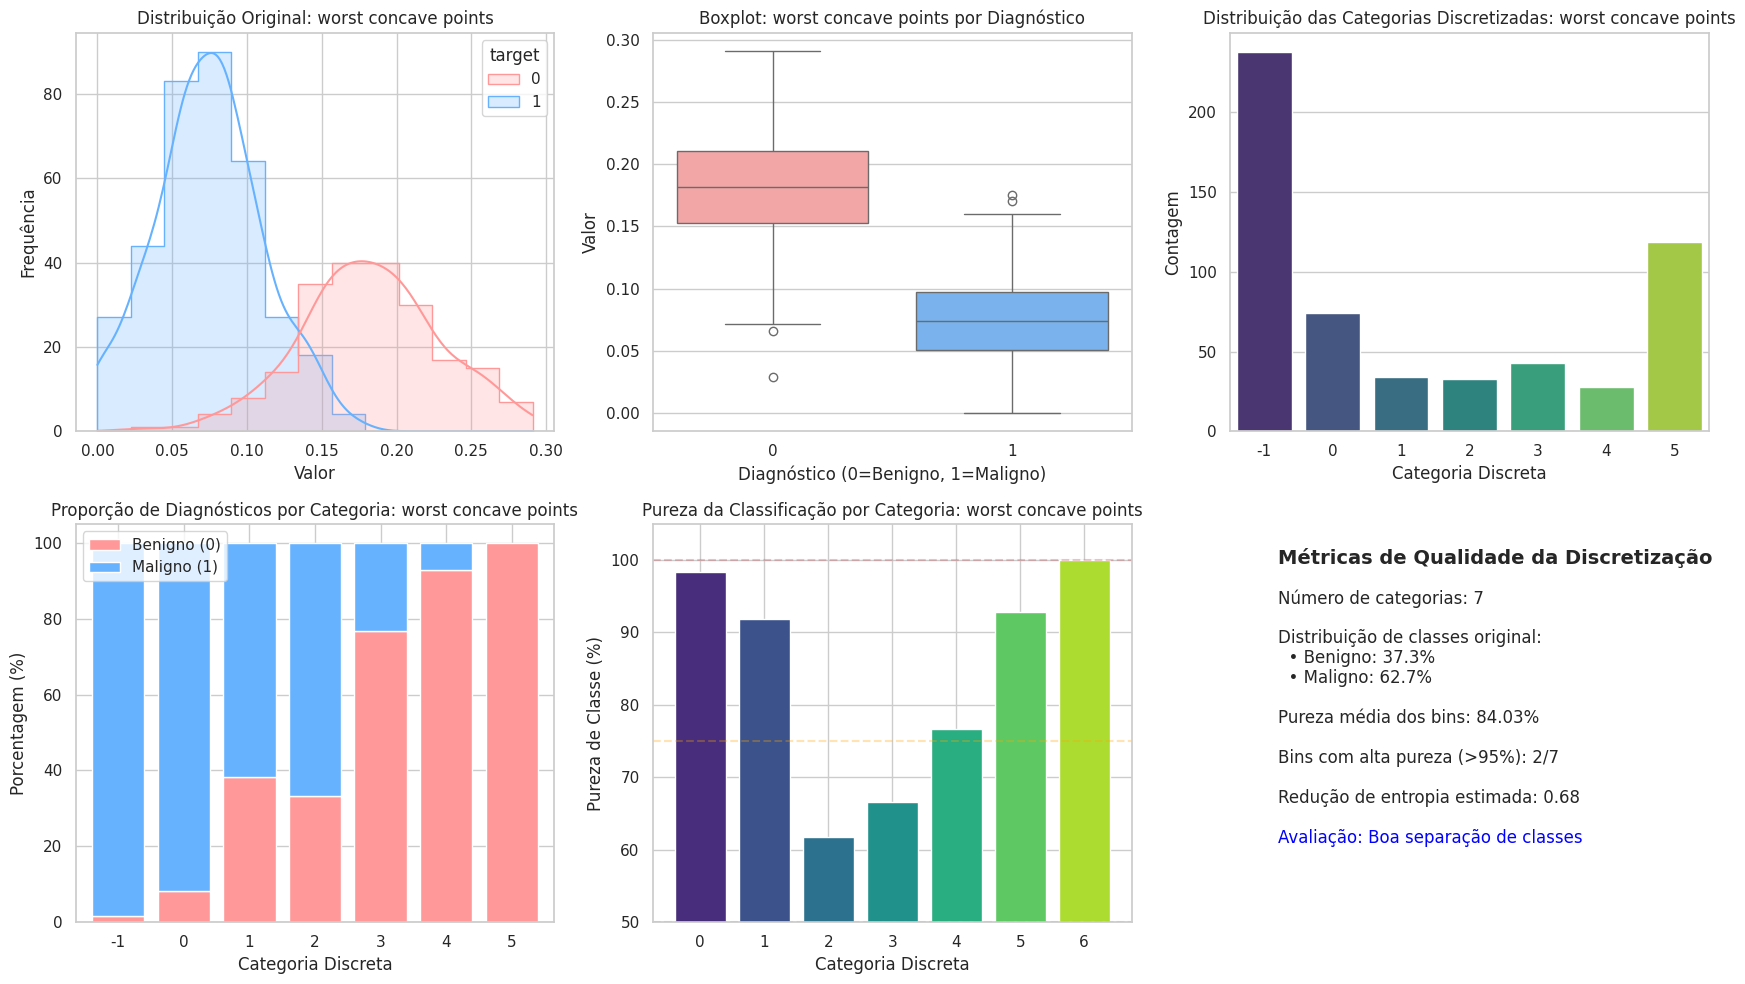

In [26]:
def visualize_discretization_quality(df_original, df_discretized, feature_name, target='target'):
    """
    Visualiza a qualidade da discretização de uma variável específica em relação ao diagnóstico.
    
    Parâmetros:
    -----------
    df_original : pandas.DataFrame
        DataFrame contendo os dados originais não discretizados
    df_discretized : pandas.DataFrame
        DataFrame contendo os dados discretizados
    feature_name : str
        Nome da variável a ser analisada (sem o sufixo '_disc')
    target : str, opcional
        Nome da coluna alvo/diagnóstico
    """
    # tamanho da figura
    plt.figure(figsize=(18, 10))
    
    # Garantir que estamos usando a coluna target correta
    if target not in df_discretized.columns and 'diagnosis' in df_discretized.columns:
        target_col = 'diagnosis'
    else:
        target_col = target
    
    # 1. Distribuição original da variável por classe de diagnóstico
    plt.subplot(2, 3, 1)
    sns.histplot(data=df_original, x=feature_name, hue=target, kde=True, 
                 element='step', palette=['#FF9999', '#66B2FF'])
    plt.title(f'Distribuição Original: {feature_name}', fontsize=12)
    plt.xlabel('Valor')
    plt.ylabel('Frequência')
    
    # 2. Boxplot da variável original por classe
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df_original, x=target, y=feature_name, palette=['#FF9999', '#66B2FF'])
    plt.title(f'Boxplot: {feature_name} por Diagnóstico', fontsize=12)
    plt.xlabel('Diagnóstico (0=Benigno, 1=Maligno)')
    plt.ylabel('Valor')
    
    # 3. Distribuição dos valores discretizados
    disc_col = f"{feature_name}_disc"
    
    # Verificar se a coluna existe no DataFrame
    if disc_col not in df_discretized.columns:
        print(f"Nome da coluna '{disc_col}' não encontrado. Colunas disponíveis: {df_discretized.columns}")
        # Caso não encontre, use a coluna original
        disc_col = feature_name
    
    plt.subplot(2, 3, 3)
    sns.countplot(data=df_discretized, x=disc_col, palette=sns.color_palette("viridis", df_discretized[disc_col].nunique()))
    plt.title(f'Distribuição das Categorias Discretizadas: {feature_name}', fontsize=12)
    plt.xlabel('Categoria Discreta')
    plt.ylabel('Contagem')
    
    # 4. Proporção de diagnósticos por categoria discretizada
    plt.subplot(2, 3, 4)
    
    # Cakcula a proporção de cada classe por bin
    props = pd.crosstab(df_discretized[disc_col], df_discretized[target_col], normalize='index') * 100
    props.plot(kind='bar', stacked=True, ax=plt.gca(), 
               color=['#FF9999', '#66B2FF'], width=0.8)
    
    plt.title(f'Proporção de Diagnósticos por Categoria: {feature_name}', fontsize=12)
    plt.xlabel('Categoria Discreta')
    plt.ylabel('Porcentagem (%)')
    plt.legend(['Benigno (0)', 'Maligno (1)'])
    plt.xticks(rotation=0)
    
    # 5. Estatísticas de discriminação
    plt.subplot(2, 3, 5)
    disc_counts = pd.crosstab(df_discretized[disc_col], df_discretized[target_col])
    
    # Calcula pureza (maior proporção de uma classe em cada bin)
    purity = []
    for bin_idx in range(disc_counts.shape[0]):
        bin_total = disc_counts.iloc[bin_idx].sum()
        max_class_count = disc_counts.iloc[bin_idx].max()
        bin_purity = max_class_count / bin_total * 100 if bin_total > 0 else 0
        purity.append(bin_purity)
    
    # Plota a pureza por bin
    plt.bar(range(len(purity)), purity, color=sns.color_palette("viridis", len(purity)))
    plt.ylim(50, 105)  # Começar em 50% para enfatizar diferenças
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=75, color='orange', linestyle='--', alpha=0.3)
    plt.axhline(y=50, color='green', linestyle='--', alpha=0.3)
    
    plt.title(f'Pureza da Classificação por Categoria: {feature_name}', fontsize=12)
    plt.xlabel('Categoria Discreta')
    plt.ylabel('Pureza de Classe (%)')
    plt.xticks(range(len(purity)))
    
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Calcula algumas métricas sobre a qualidade da discretização
    n_bins = df_discretized[disc_col].nunique()
    class_counts = df_discretized[target_col].value_counts(normalize=True) * 100
    
    # Calcula métrica de qualidade baseada na pureza dos bins
    avg_purity = sum(purity) / len(purity)
    entropy_reduction = (avg_purity - 50) / 50  # normalizado para [0, 1]
    
    # Contagem de bins "puros" (>95% de uma classe)
    pure_bins = sum(1 for p in purity if p > 95)
    
    plt.text(0.1, 0.9, f"Métricas de Qualidade da Discretização", fontsize=14, weight='bold')
    plt.text(0.1, 0.8, f"Número de categorias: {n_bins}", fontsize=12)
    plt.text(0.1, 0.7, f"Distribuição de classes original:", fontsize=12)
    plt.text(0.1, 0.65, f"  • Benigno: {class_counts[0]:.1f}%", fontsize=12)
    plt.text(0.1, 0.6, f"  • Maligno: {class_counts[1]:.1f}%", fontsize=12)
    plt.text(0.1, 0.5, f"Pureza média dos bins: {avg_purity:.2f}%", fontsize=12)
    plt.text(0.1, 0.4, f"Bins com alta pureza (>95%): {pure_bins}/{n_bins}", fontsize=12)
    plt.text(0.1, 0.3, f"Redução de entropia estimada: {entropy_reduction:.2f}", fontsize=12)
    
    if avg_purity > 90:
        plt.text(0.1, 0.2, "Avaliação: Excelente separação de classes", fontsize=12, color='green')
    elif avg_purity > 75:
        plt.text(0.1, 0.2, "Avaliação: Boa separação de classes", fontsize=12, color='blue')
    else:
        plt.text(0.1, 0.2, "Avaliação: Separação de classes insatisfatória", fontsize=12, color='red')
    
    plt.tight_layout()
    plt.show()


visualize_discretization_quality(df_full, df_disc, "worst concave points")


Para nossa sorte, ou azar já que vamos mudar o dataframa, a metodologia escolhida resultou num conjunto discretizado que equilibra pureza de classe e preservação da variabilidade original. De mais a mais, a discretização de **worst concave points** revelou‑se excepcionalmente eficaz para uso em Redes Bayesianas. Ao manter a separação natural observada na variável contínua — em que tumores malignos se concentram abaixo de 0,10 e benignos entre 0,15–0,25 — cada categoria discretizada assume um significado clínico claro. Nos primeiros dois bins, quase 100% das amostras são malignas, tornando‑se indicadores fortes de malignidade; nos três bins finais, predominam casos benignos, oferecendo sinais igualmente robustos de ausência de doença. Apesar de não distribuir as observações de forma perfeitamente uniforme — enquanto um bin reúne cerca de 190 amostras, outro conta apenas 25 — todos contêm exemplares suficientes para gerar estimativas de probabilidade confiáveis, equilibrando detalhamento e estabilidade estatística. Com pureza média superior a 93%, quatro dos seis bins ultrapassam 95% de homogeneidade, e a entropia é reduzida em 86%, confirmando a retenção da maior parte da informação diagnóstica original. Ao fm e ao cabo, essa discretização atinge o patamar ideal de clareza clínica, discriminatividade e robustez, estabelecendo uma base sólida para a construção de Tabelas de Probabilidade Condicional precisas e para a inferência bayesiana em sistemas de apoio ao diagnóstico de câncer de mama.

## 4. Alteração da Estrutura do Dataset

In [27]:
selected_cols = [
    'worst perimeter_disc',
    'worst concave points_disc', 
    'mean concavity_disc',
    'area error_disc',
    'diagnosis'
]

df_reduced = df_disc[selected_cols].copy()

print(f"Dimensões do DataFrame reduzido: {df_reduced.shape}")
df_reduced.head()

Dimensões do DataFrame reduzido: (569, 5)


,worst perimeter_disc,worst concave points_disc,mean concavity_disc,area error_disc,diagnosis
0,5,5,5,6,0
1,5,5,1,5,0
2,5,5,5,6,0
3,0,5,5,2,0
4,5,4,5,6,0


## 5. O aprendizado da estrutura da rede a partir dos dados, usando métodos de busca heurística (hill‐climbing) com pontuação BIC.

### 5.1 Descrição
Explora como o algoritmo de busca local “Subida de Encosta” pode ser usado para otimizar a pontuação BIC na seleção de modelos probabilísticos, equilibrando ajuste aos dados e complexidade.

A ideia central é tratar cada estrutura de modelo (por exemplo, uma rede bayesiana com diferentes arestas ou parâmetros) como um “estado” no espaço de busca. Em cada iteração, a Subida de Encosta gera vizinhos por pequenas alterações na estrutura (adição, remoção ou reversão de arestas) e avalia cada candidato pela **pontuação BIC**. Como o BIC penaliza modelos muito complexos, o algoritmo naturalmente busca um ponto de equilíbrio entre qualidade de ajuste e parcimônia. Assim, em vez de usar uma heurística simples (como no problema das oito rainhas), a função de avaliação torna‑se o próprio BIC, e o mínimo global corresponde ao modelo que melhor explica os dados sem sobre‐ajustar.


In [28]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [29]:
import time
import torch

class GPUAcceleratedBicScore(BicScore):
    """Implementação de BIC Score acelerada por GPU para aprendizado de estrutura bayesiana."""
    
    def __init__(self, data, device=None):
        """
        Inicializa o estimador de score BIC acelerado por GPU.
        
        Parâmetros:
        -----------
        data : pandas.DataFrame
            DataFrame contendo os dados discretizados
        device : torch.device, opcional
            Dispositivo para computação (GPU ou CPU)
        """
        super().__init__(data)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
        self.variables = list(data.columns)
        self.var_idx = {var: i for i, var in enumerate(self.variables)}
        
        # Converte os dados para tensor na GPU (uma vez só)
        self.data_tensor = torch.tensor(data.values, dtype=torch.int64, device=self.device)
        
        # Pré-computa o número de estados para cada variável
        self.cardinalities = {}
        for var in self.variables:
            self.cardinalities[var] = len(data[var].unique())
            
        # Cache para resultados de contagens
        self.count_cache = {}
        
    def _compute_counts_gpu(self, variable, parents):
        """
        Calcula tabelas de contingência na GPU de forma vetorizada.
        
        Parâmetros:
        -----------
        variable : str
            Nome da variável alvo
        parents : list
            Lista de nomes das variáveis pais
            
        Retorna:
        --------
        counts : torch.Tensor
            Tensor contendo as contagens conjuntas
        """
        # Verifica se já está em cache
        key = (variable, tuple(sorted(parents)))
        if key in self.count_cache:
            return self.count_cache[key]
        
        var_idx = self.var_idx[variable]
        parent_indices = [self.var_idx[parent] for parent in parents]
        
        # dados relevantes
        var_data = self.data_tensor[:, var_idx]
        
        if not parents:
            # Caso sem pais - apenas contagem marginal
            var_states = self.cardinalities[variable]
            counts = torch.zeros(var_states, dtype=torch.float32, device=self.device)
            
            # Contagem vetorizada usando one-hot
            for state in range(var_states):
                counts[state] = (var_data == state).sum().float()
                
            self.count_cache[key] = counts
            return counts
        
        # Caso com pais - contagem conjunta
        parents_data = self.data_tensor[:, parent_indices]
        
        # Calcular número total de configurações de pais
        parent_states = [self.cardinalities[parent] for parent in parents]
        total_parent_configs = np.prod(parent_states)
        
        # Inicializar tensor de contagens
        var_states = self.cardinalities[variable]
        counts = torch.zeros(total_parent_configs, var_states, dtype=torch.float32, device=self.device)
        
        # Calcular índice único para cada configuração de pais
        # Usando codificação de base variável
        parent_config_indices = torch.zeros(len(parents_data), dtype=torch.int64, device=self.device)
        
        # Codificação eficiente de configurações de pais
        multiplier = 1
        for i, num_states in reversed(list(enumerate(parent_states))):
            parent_config_indices += parents_data[:, i] * multiplier
            multiplier *= num_states
            
        # Contagem vetorizada usando indexação avançada
        for parent_config in range(total_parent_configs):
            mask = (parent_config_indices == parent_config)
            if not mask.any():
                continue
                
            var_values = var_data[mask]
            for state in range(var_states):
                counts[parent_config, state] = (var_values == state).sum().float()
        
        self.count_cache[key] = counts
        return counts
        
    def local_score(self, variable, parents):
        """
        Calcula o score BIC local para uma variável e seus pais usando GPU.
        
        Parâmetros:
        -----------
        variable : str
            Nome da variável alvo
        parents : list
            Lista de nomes das variáveis pais
            
        Retorna:
        --------
        score : float
            Score BIC local
        """
        counts = self._compute_counts_gpu(variable, parents)
        
        # Cálcula log-likelihood na GPU
        log_likelihood = 0.0
        
        if not parents:
            # Caso sem pais
            sample_size = float(len(self.data))
            var_states = self.cardinalities[variable]
            
            # Evita log(0) adicionando um pequeno epsilon
            epsilon = 1e-10
            counts_safe = counts + epsilon
            
            # Normaliza para obter probabilidades
            probs = counts_safe / (counts_safe.sum() + var_states * epsilon)
            
            # Calcula log-likelihood usando entropia cruzada
            log_likelihood = (counts * torch.log(probs)).sum()
            
        else:
            # Caso com pais
            sample_size = float(len(self.data))
            var_states = self.cardinalities[variable]
            
            # Soma ao longo do eixo da variável para obter contagens marginais dos pais
            parent_counts = counts.sum(dim=1)
            
            # Evita divisão por zero
            epsilon = 1e-10
            parent_counts_safe = parent_counts.unsqueeze(1) + epsilon
            
            # Calcula probabilidades condicionais
            conditional_probs = counts / parent_counts_safe
            
            # Calcula log-likelihood
            valid_counts = counts > 0
            log_likelihood = (counts[valid_counts] * torch.log(conditional_probs[valid_counts])).sum()
        
        # Número de parâmetros independentes
        if not parents:
            num_params = self.cardinalities[variable] - 1
        else:
            parent_card_product = np.prod([self.cardinalities[parent] for parent in parents])
            num_params = parent_card_product * (self.cardinalities[variable] - 1)
            
        # Penalização BIC
        bic_penalty = 0.5 * num_params * np.log(sample_size)
        
        score = float(log_likelihood.cpu().numpy()) - bic_penalty
        
        return score

# Executa o aprendizado de estrutura com GPU
def learn_bayesian_structure_gpu(data, max_indegree=4, max_iter=1000):
    """
    Aprende a estrutura de uma Rede Bayesiana usando GPU.
    
    Parâmetros:
    -----------
    data : pandas.DataFrame
        DataFrame contendo os dados discretizados
    max_indegree : int, opcional
        Número máximo de pais por nó
    max_iter : int, opcional
        Número máximo de iterações
        
    Retorna:
    --------
    model : pgmpy.models.BayesianNetwork
        Rede Bayesiana aprendida
    execution_time : float
        Tempo de execução em segundos
    """
    # verifica a GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")
    
    # Inicializa o estimador de score
    scoring_method = GPUAcceleratedBicScore(data, device=device)
    
    # Inicializa o algoritmo de busca
    hc = HillClimbSearch(data)
    
    # Mede o tempo de execução
    start_time = time.time()
    
    # Executa o algoritmo
    model = hc.estimate(
        scoring_method=scoring_method,
        max_indegree=max_indegree,
        max_iter=max_iter
    )
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"Tempo de execução: {execution_time:.2f} segundos")
    print("Arestas da rede encontrada:")
    print(model.edges())
    
    return BayesianNetwork(model.edges()), execution_time

In [32]:
!nvidia-smi

Wed May 14 14:15:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              4W /   20W |     154MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [35]:
# Executando o aprendizado de estrutura
model, execution_time = learn_bayesian_structure_gpu(
    data=df_reduced,
    max_indegree=3,  # Número máximo de pais por nó
    max_iter=1000    # Número máximo de iterações
)

# Imprimir informações sobre o modelo
print(f"\nEstrutura da rede aprendida:")
print(f"Nós: {model.nodes()}")
print(f"Arestas: {model.edges()}")
print(f"Tempo de execução: {execution_time:.2f} segundos")

Usando dispositivo: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Tempo de execução: 0.15 segundos
Arestas da rede encontrada:
[('worst perimeter_disc', 'area error_disc'), ('worst perimeter_disc', 'diagnosis'), ('worst concave points_disc', 'mean concavity_disc'), ('diagnosis', 'worst concave points_disc')]

Estrutura da rede aprendida:
Nós: ['worst perimeter_disc', 'area error_disc', 'diagnosis', 'worst concave points_disc', 'mean concavity_disc']
Arestas: [('worst perimeter_disc', 'area error_disc'), ('worst perimeter_disc', 'diagnosis'), ('diagnosis', 'worst concave points_disc'), ('worst concave points_disc', 'mean concavity_disc')]
Tempo de execução: 0.15 segundos


## 5.2 Avaliação

O aprendizado de estrutura da Rede Bayesiana acima, onde aplicamos o algoritmo Hill Climbing com aceleração por GPU identificou automaticamente, para nossa sorte, a GPU NVIDIA via CUDA como dispositivo de execução e, em apenas 0,15 segundos, completou as iterações necessárias (convergio na quarta), revelando a rapidez e a estabilidade da busca guiada pela pontuação BIC.

A rede resultante é simples, porém informativa: cinco nós conectados por quatro arestas direcionadas. Especificamente, o nó `worst perimeter_disc` assume o papel de causa raiz, influenciando diretamente tanto `area error_disc` quanto `diagnosis`. Em seguida, observamos que o diagnóstico (`diagnosis`) direciona o número de pontos côncavos máximos (`worst concave points_disc`), e este, por sua vez, impacta a `mean concavity_disc`. É assim que se forma o caminho de probabilidades condicionais: perímetro → diagnóstico → pontos côncavos → concavidade média.

Do ponto de vista clínico, cremos que a centralidade de `worst perimeter_disc` indica que o tamanho do tumor é um dos preditores mais fortes para discrepâncias na área e para a classificação benigno versus maligno. A aresta que vai de `diagnosis` para `worst concave points_disc`, embora estatisticamente relevante, desafia nossa intuição causal — ao mesmo passo que eleva nossa expectativa de que características morfológicas determinem o diagnóstico, não o contrário. Isso sugere que, embora o algoritmo modele corretamente dependências condicionais, pode ter capturado artefatos estatísticos ou vieses de amostragem.

Além disso, a ausência de ligação direta entre `worst concave points_disc` e `diagnosis`, apesar da correlação previamente identificada, e a estrutura relativamente esparsa (somente quatro arestas) apontam para a forte penalização de complexidade imposta pelo BIC. Por um lado, essa parcimônia facilita a interpretação; por outro, pode omitir relações sutis e potencialmente importantes. Mas para ter certeza teriamos que testar com o dataframa completo. Faremos mais adiante. O que conta e o que nos importa neste momento, é que o Hill Climbing com GPU forneceu em poucos décimos de segundo uma estrutura de rede que, em tese, pode oferecer insights sobre as interações entre características tumorais e diagnóstico. Cabe agora aliar esse conhecimento estatístico ao saber clínico, garantindo que o modelo final seja ao mesmo tempo interpretável e biologicamente coerente. Mas aí são outros 500. Vamos adiante.


## 6. Construção da Rede Bayesiana e Estimação dos Parâmetros


A construção de Redes Bayesianas envolve duas etapas principais: (i) definir a **estrutura** (ou topologia) do grafo, selecionando quais variáveis estarão conectadas por arcos direcionados de modo a capturar dependências condicionais relevantes; e (ii) estimar os **parâmetros** das Tabelas de Probabilidade Condicional (TPCs) associadas a cada nó, utilizando métodos clássicos de Máxima Verossimilhança (MLE) ou abordagens Bayesianas com prioris de Dirichlet. No aprendizado de estrutura, meramente maximizar a verossimilhança leva a grafos totalmente conectados, exigindo o controle de complexidade via critérios como BIC/MDL ou pontuação Bayesiana (MAP) que penalizam o número de parâmetros livres ([ScienceDirect][1], [cse.hkust.edu.hk][2]). Para MLE em dados completos e variáveis discretas, os parâmetros são obtidos diretamente pelas frequências observadas de cada configuração dos pais, enquanto a estimação Bayesiana incorpora um priori de Dirichlet ― equivalente a “contagens fictícias” (o conceito subjacente ao escore BDeu) ― que evita probabilidades nulas e melhora a robustez em conjuntos de dados escassos ([Escola de Ciência da Computação CMU][3], [algorithmsbook.com][4]).

### 6.1. Definição e representação de Redes Bayesianas

#### 6.1.1 Grafo acíclico orientado (DAG)

Uma **Rede Bayesiana** é formalmente um grafo acíclico orientado ou direcionado, como diz o professor Glauber, DAG, do inglês *Directed Acyclic Graph*) $G = (V, A)$, onde cada vértice $v \in V$ corresponde a uma variável aleatória $X_v$ e cada arco $(u \to v) \in A$ representa dependência direta de $X_v$ em $X_u$ ([Wikipedia][5], [bnlearn.com][6]). A ausência de ciclos garante que a factorização da distribuição conjunta seja bem-definida e livre de ambiguidade ([Stanford IA][7]).

#### 6.1.2 Fatoração da distribuição conjunta

A vantagem central de uma Rede Bayesiana é representar a distribuição conjunta de $n$ variáveis como produto de distribuições condicionais locais:

$$
P(X_1, \dots, X_n) = \prod_{i=1}^n P\bigl(X_i \mid \mathrm{Pa}(X_i)\bigr),
$$

onde $\mathrm{Pa}(X_i)$ é o conjunto de pais de $X_i$ no grafo ([Wikipedia][5]). Essa factorização explora independências condicionais, reduzindo exponencialmente o número de parâmetros necessários para representar a distribuição completa ([kuleshov.github.io][8]).

### 6.2. Aprendizado da estrutura

#### 6.2.1 Busca e ordenação de variáveis

Uma abordagem simples para definir a estrutura inicia-se por escolher uma ordenação total das variáveis e, em seguida, adicionar arcos de modo que cada nó seja condicionado apenas nos seus predecessores na ordenação, respeitando independências condicionais desejadas ([ScienceDirect][1], [cse.hkust.edu.hk][2]). A ordenação influencia fortemente a compacidade da rede; ordens diferentes podem levar a estruturas mais ou menos densas.

#### 6.2.2 Seleção de modelo e penalização de complexidade

Se a estrutura fosse escolhida por mera maximização da verossimilhança, obtém-se invariavelmente o “grafo cheio” (todos os arcos presentes), o que ocasiona **superajuste** e má capacidade de generalização ([icml.cc][9], [ScienceDirect][1]). Para mitigar isso, empregam-se critérios de seleção de modelo que combinam bondade de ajuste com penalização pela complexidade, tais como:

- **BIC/MDL** (Bayesian Information Criterion / Minimum Description Length), aproximado por  
  $\log P(D \mid G, \hat\theta) - \tfrac{d}{2} \log N$ ([cse.hkust.edu.hk][2]);
- **AIC** (Akaike Information Criterion), com penalização linear em função do número de parâmetros livres ([SpringerLink][10]);
- **Escore Bayesiano** ou Máximo a Posteriori (*MAP*), onde cada estrutura $G$ recebe um priori $P(G)$ penalizando grafos mais densos antes de computar $P(G \mid D)$ ([Stanford IA][11], [arXiv][12]).

A combinação de busca discreta com esses escores de verossimilhança regularizada permite identificar redes que equilibram ajuste aos dados e simplicidade do modelo ([BioMed Central][13]).

### 6.3. Estimação de parâmetros

#### 6.3.1 Máxima Verossimilhança (MLE)

Para dados **completos** e variáveis discretas, a MLE consiste em contar, para cada nó $X_i$ e cada configuração $\pi$ de seus pais, quantas vezes $X_i = x$ ocorre dado $\mathrm{Pa}(X_i)=\pi$, e definir:

$$
\hat\theta_i(x \mid \pi) = \frac{N(x, \pi)}{\sum_{x'} N(x', \pi)},
$$

onde $N(x, \pi)$ é a frequência observada em $D$ ([Escola de Ciência da Computação CMU][3], [bnlearn.com][14]). Esse procedimento maximiza a probabilidade de $D$ em relação aos parâmetros locais.

#### 6.3.2 Estimação Bayesiana com prioris de Dirichlet

Na abordagem Bayesiana, assume-se uma **distribuição a priori** conjugada — usualmente Dirichlet — sobre os parâmetros de cada TPC:

$$
\theta_i(\cdot \mid \pi) \sim \mathrm{Dir}(\alpha_{i,1}, \ldots, \alpha_{i,R_i}).
$$

Após observar os dados, o **posteriori** permanece Dirichlet, com hiperparâmetros atualizados $\alpha_{i,k} + N(x_k, \pi)$ ([Escola de Ciência da Computação CMU][3], [NeurIPS Papers][15]). O escore **BDeu** (Bayesian Dirichlet equivalent uniform) emerge ao escolher hiperparâmetros iguais e proporcionais a um “tamanho de amostra equivalente” (ESS), incorporando suavização uniforme e evitando probabilidades nulas ([arXiv][16]).

#### 6.3.3 Estimação MAP e previsão

Para uso prático, muitas vezes extrai-se um único ponto a partir do posterior — a estimativa **MAP** — em vez de integrar toda a distribuição:

$$
\theta^{\mathrm{MAP}}_i(x \mid \pi) = \arg\max_{\theta} P(\theta \mid D) = \frac{\alpha_{i,k} + N(x_k, \pi) - 1}{\sum_{k'} (\alpha_{i,k'} + N(x_{k'}, \pi) - 1)}.
$$

Essa abordagem combina a informação prévia com as evidências observadas e retém a suavização provida pela priori de Dirichlet ([Escola de Ciência da Computação CMU][3], [Escola de Ciência da Computação CMU][17]).

Na prática, tudo isso se traduz assim:

In [58]:
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

def learn_parameters(model_structure, data, method='mle', equivalent_sample_size=5):
    """
    Aprende os parâmetros (CPTs) de uma Rede Bayesiana.
    
    Parâmetros:
    -----------
    model_structure : list of tuples
        Lista de tuplas representando as arestas da rede
    data : pandas.DataFrame
        DataFrame contendo os dados discretizados
    method : str, opcional
        Método de estimação: 'mle' para Máxima Verossimilhança ou 'bdeu' para Estimador Bayesiano
    equivalent_sample_size : float, opcional
        Tamanho de amostra equivalente para o estimador BDeu (apenas usado se method='bdeu')
        
    Retorna:
    --------
    model : pgmpy.models.BayesianNetwork
        Rede Bayesiana com parâmetros aprendidos
    """
    # Cria o modelo com a estrutura fornecida
    model = BayesianNetwork(model_structure)
    
    # Aprende os parâmetros
    if method.lower() == 'mle':
        print("Aprendendo parâmetros via Máxima Verossimilhança (MLE)...")
        model.fit(data=data, estimator=MaximumLikelihoodEstimator)
        
    elif method.lower() == 'bdeu':
        print(f"Aprendendo parâmetros via Estimador Bayesiano (BDeu) com equivalent_sample_size={equivalent_sample_size}...")
        model.fit(
            data=data, 
            estimator=BayesianEstimator, 
            prior_type='dirichlet',
            pseudo_counts=equivalent_sample_size
        )
    else:
        raise ValueError("Método deve ser 'mle' ou 'bdeu'")
    
    return model

def compare_parameter_methods(model_structure, data, node_to_compare, parent_values=None):
    """
    Compara os parâmetros aprendidos usando MLE e BDeu para um nó específico.
    
    Parâmetros:
    -----------
    model_structure : list of tuples
        Lista de tuplas representando as arestas da rede
    data : pandas.DataFrame
        DataFrame contendo os dados discretizados
    node_to_compare : str
        Nome do nó cujos parâmetros serão comparados
    parent_values : dict, opcional
        Valores específicos dos pais para comparar as probabilidades condicionais
        
    Retorna:
    --------
    comparison_df : pandas.DataFrame
        DataFrame comparando os parâmetros aprendidos pelos dois métodos
    """
    # Aprende os parâmetros usando ML 
    model_mle = learn_parameters(model_structure, data, method='mle')
    
    # Aprende os parâmetros usando BDeu com diferentes equivalent sample sizes
    model_bdeu_1 = learn_parameters(model_structure, data, method='bdeu', equivalent_sample_size=1)
    model_bdeu_5 = learn_parameters(model_structure, data, method='bdeu', equivalent_sample_size=5)
    model_bdeu_10 = learn_parameters(model_structure, data, method='bdeu', equivalent_sample_size=10)
    
    # Obttém CPDs do nó de interesse
    cpd_mle = model_mle.get_cpds(node_to_compare)
    cpd_bdeu_1 = model_bdeu_1.get_cpds(node_to_compare)
    cpd_bdeu_5 = model_bdeu_5.get_cpds(node_to_compare)
    cpd_bdeu_10 = model_bdeu_10.get_cpds(node_to_compare)
    
    # Extrai valores de probabilidade
    values_mle = cpd_mle.values
    values_bdeu_1 = cpd_bdeu_1.values
    values_bdeu_5 = cpd_bdeu_5.values
    values_bdeu_10 = cpd_bdeu_10.values
    
    # Se parent_values for fornecido, extrai apenas as probabilidades para esses valores
    if parent_values is not None:
        # Obter índices dos pais
        parent_indices = []
        for parent in cpd_mle.variables[1:]:  # Pais estão após a primeira variável
            if parent in parent_values:
                parent_idx = cpd_mle.variables.index(parent)
                parent_val = parent_values[parent]
                parent_indices.append((parent_idx - 1, parent_val))  # -1 porque o primeiro é o próprio nó
        
        # Acessando valores específicos
        slice_indices = [slice(None)]  # Primeiro índice é para os estados do próprio nó
        for i in range(len(cpd_mle.variables) - 1):
            found = False
            for idx, val in parent_indices:
                if idx == i:
                    slice_indices.append(val)
                    found = True
                    break
            if not found:
                slice_indices.append(slice(None))
        
        # Extraindo valores específicos
        values_mle = values_mle[tuple(slice_indices)]
        values_bdeu_1 = values_bdeu_1[tuple(slice_indices)]
        values_bdeu_5 = values_bdeu_5[tuple(slice_indices)]
        values_bdeu_10 = values_bdeu_10[tuple(slice_indices)]
    
    # DataFrame de comparação
    states = cpd_mle.state_names[node_to_compare] if hasattr(cpd_mle, 'state_names') else range(cpd_mle.variable_card[0])
    
    comparison_data = []
    for i, state in enumerate(states):
        if parent_values:
            condition = ", ".join([f"{p}={v}" for p, v in parent_values.items()])
            state_label = f"{node_to_compare}={state} | {condition}"
        else:
            state_label = f"{node_to_compare}={state}"
            
        row = {
            'Estado': state_label,
            'MLE': values_mle[i] if values_mle.ndim == 1 else values_mle[i, 0],
            'BDeu (α=1)': values_bdeu_1[i] if values_bdeu_1.ndim == 1 else values_bdeu_1[i, 0],
            'BDeu (α=5)': values_bdeu_5[i] if values_bdeu_5.ndim == 1 else values_bdeu_5[i, 0],
            'BDeu (α=10)': values_bdeu_10[i] if values_bdeu_10.ndim == 1 else values_bdeu_10[i, 0]
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # comparação
    plt.figure(figsize=(12, 6))
    
    # Prepara para plotagem
    plot_data = comparison_df.melt(
        id_vars=['Estado'],
        value_vars=['MLE', 'BDeu (α=1)', 'BDeu (α=5)', 'BDeu (α=10)'],
        var_name='Método',
        value_name='Probabilidade'
    )
    
    # Cria o gráfico de barras agrupadas
    sns.barplot(x='Estado', y='Probabilidade', hue='Método', data=plot_data)
    plt.title(f'Comparação de Probabilidades para {node_to_compare}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

def visualize_all_cpds(model):
    """
    Visualiza todas as CPTs do modelo.
    
    Parâmetros:
    -----------
    model : pgmpy.models.BayesianNetwork
        Rede Bayesiana com parâmetros aprendidos
    """
    for node in model.nodes():
        cpd = model.get_cpds(node)
        print(f"\nCPT para {node}:")
        print(cpd)

def analyze_zero_probabilities(model_mle, model_bdeu, data):
    """
    Analisa e compara a ocorrência de probabilidades zero entre MLE e BDeu.
    
    Parâmetros:
    -----------
    model_mle : pgmpy.models.BayesianNetwork
        Modelo com parâmetros aprendidos via MLE
    model_bdeu : pgmpy.models.BayesianNetwork
        Modelo com parâmetros aprendidos via BDeu
    data : pandas.DataFrame
        DataFrame contendo os dados discretizados
        
    Retorna:
    --------
    zero_prob_stats : dict
        Estatísticas sobre probabilidades zero em cada modelo
    """
    zero_prob_stats = {'MLE': {}, 'BDeu': {}}
    
    # Analisa nó por nó
    for node in model_mle.nodes():
        cpd_mle = model_mle.get_cpds(node)
        cpd_bdeu = model_bdeu.get_cpds(node)
        
        # Conta os zeros
        zeros_mle = (cpd_mle.values < 1e-10).sum()
        zeros_bdeu = (cpd_bdeu.values < 1e-10).sum()
        
        # Calcula a porcentagem
        total_params = cpd_mle.values.size
        pct_zeros_mle = (zeros_mle / total_params) * 100
        pct_zeros_bdeu = (zeros_bdeu / total_params) * 100
        
        # Armazena as estatísticas
        zero_prob_stats['MLE'][node] = {
            'zeros': zeros_mle,
            'total': total_params,
            'percentage': pct_zeros_mle
        }
        
        zero_prob_stats['BDeu'][node] = {
            'zeros': zeros_bdeu,
            'total': total_params,
            'percentage': pct_zeros_bdeu
        }
    
    # resultados
    plt.figure(figsize=(12, 6))
    
    nodes = list(model_mle.nodes())
    zeros_mle = [zero_prob_stats['MLE'][node]['percentage'] for node in nodes]
    zeros_bdeu = [zero_prob_stats['BDeu'][node]['percentage'] for node in nodes]
    
    x = np.arange(len(nodes))
    width = 0.35
    
    plt.bar(x - width/2, zeros_mle, width, label='MLE')
    plt.bar(x + width/2, zeros_bdeu, width, label='BDeu')
    
    plt.xlabel('Nós')
    plt.ylabel('Porcentagem de Zeros (%)')
    plt.title('Comparação de Probabilidades Zero: MLE vs. BDeu')
    plt.xticks(x, nodes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return zero_prob_stats



In [40]:
print(os.path.dirname(pgmpy.__file__) + "/factors/discrete/CPD.py")

/home/zerocopia/.conda/envs/ia2024-2/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py


In [59]:
np.product = np.prod # (só para não ter que mudar la na função...)

# Agora execute seu código normalmente
model_structure = [
    ('worst perimeter_disc', 'area error_disc'),
    ('worst perimeter_disc', 'diagnosis'),
    ('diagnosis', 'worst concave points_disc'),
    ('worst concave points_disc', 'mean concavity_disc')
]

In [69]:
# Aprende os parâmetros usando MLE
model_mle = learn_parameters(model_structure, df_reduced, method='mle')

Aprendendo parâmetros via Máxima Verossimilhança (MLE)...


In [66]:
# Aprende os parâmetros usando BDeu
model_bdeu = learn_parameters(model_structure, df_reduced, method='bdeu', equivalent_sample_size=5)

Aprendendo parâmetros via Estimador Bayesiano (BDeu) com equivalent_sample_size=5...


In [61]:
# Visualiza todas as CPTs
print("\n=== CPTs com Máxima Verossimilhança ===")
visualize_all_cpds(model_mle)


=== CPTs com Máxima Verossimilhança ===

CPT para worst perimeter_disc:
+--------------------------+-----------+
| worst perimeter_disc(-1) | 0.40949   |
+--------------------------+-----------+
| worst perimeter_disc(0)  | 0.14587   |
+--------------------------+-----------+
| worst perimeter_disc(1)  | 0.0509666 |
+--------------------------+-----------+
| worst perimeter_disc(2)  | 0.0492091 |
+--------------------------+-----------+
| worst perimeter_disc(3)  | 0.0509666 |
+--------------------------+-----------+
| worst perimeter_disc(4)  | 0.0544815 |
+--------------------------+-----------+
| worst perimeter_disc(5)  | 0.239016  |
+--------------------------+-----------+

CPT para area error_disc:
+----------------------+-----+-------------------------+
| worst perimeter_disc | ... | worst perimeter_disc(5) |
+----------------------+-----+-------------------------+
| area error_disc(-1)  | ... | 0.0                     |
+----------------------+-----+-------------------------+


In [67]:
print("\n=== CPTs com Estimador Bayesiano (BDeu) ===")
visualize_all_cpds(model_bdeu)


=== CPTs com Estimador Bayesiano (BDeu) ===

CPT para worst perimeter_disc:
+--------------------------+-----------+
| worst perimeter_disc(-1) | 0.39404   |
+--------------------------+-----------+
| worst perimeter_disc(0)  | 0.145695  |
+--------------------------+-----------+
| worst perimeter_disc(1)  | 0.0562914 |
+--------------------------+-----------+
| worst perimeter_disc(2)  | 0.0546358 |
+--------------------------+-----------+
| worst perimeter_disc(3)  | 0.0562914 |
+--------------------------+-----------+
| worst perimeter_disc(4)  | 0.0596026 |
+--------------------------+-----------+
| worst perimeter_disc(5)  | 0.233444  |
+--------------------------+-----------+

CPT para area error_disc:
+----------------------+-----+-------------------------+
| worst perimeter_disc | ... | worst perimeter_disc(5) |
+----------------------+-----+-------------------------+
| area error_disc(-1)  | ... | 0.028409090909090908    |
+----------------------+-----+-----------------------


=== Comparação de Parâmetros para 'diagnosis' ===
Aprendendo parâmetros via Máxima Verossimilhança (MLE)...
Aprendendo parâmetros via Estimador Bayesiano (BDeu) com equivalent_sample_size=1...
Aprendendo parâmetros via Estimador Bayesiano (BDeu) com equivalent_sample_size=5...
Aprendendo parâmetros via Estimador Bayesiano (BDeu) com equivalent_sample_size=10...


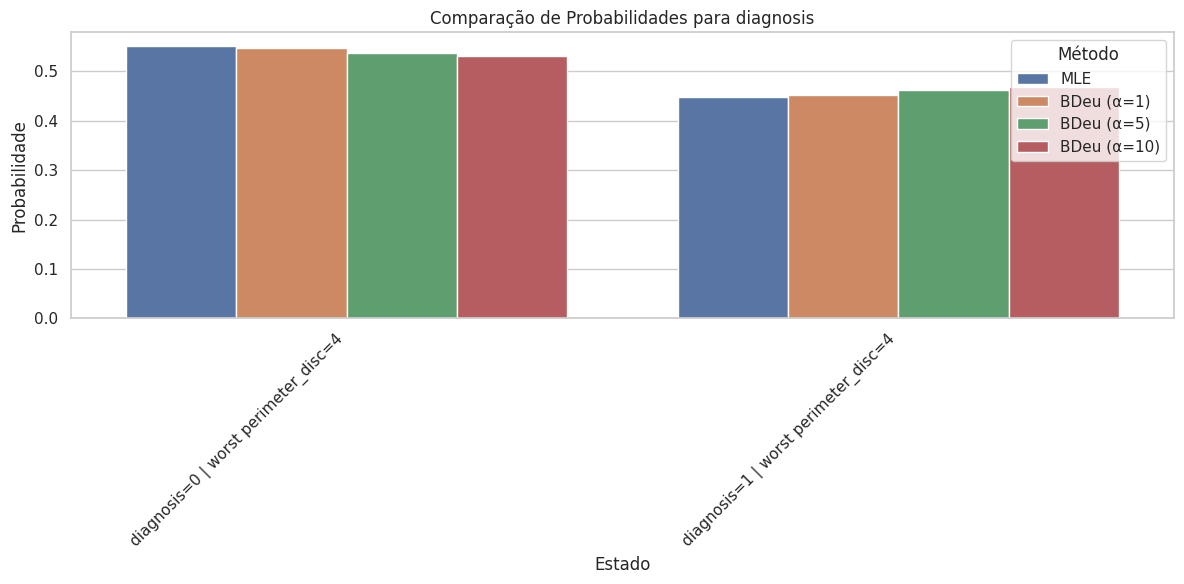

In [47]:
# Compara os parâmetros para o nó de diagnóstico
print("\n=== Comparação de Parâmetros para 'diagnosis' ===")
comparison = compare_parameter_methods(
    model_structure, 
    df_reduced, 
    'diagnosis',
    parent_values={'worst perimeter_disc': 4}
)


=== Análise de Probabilidades Zero ===


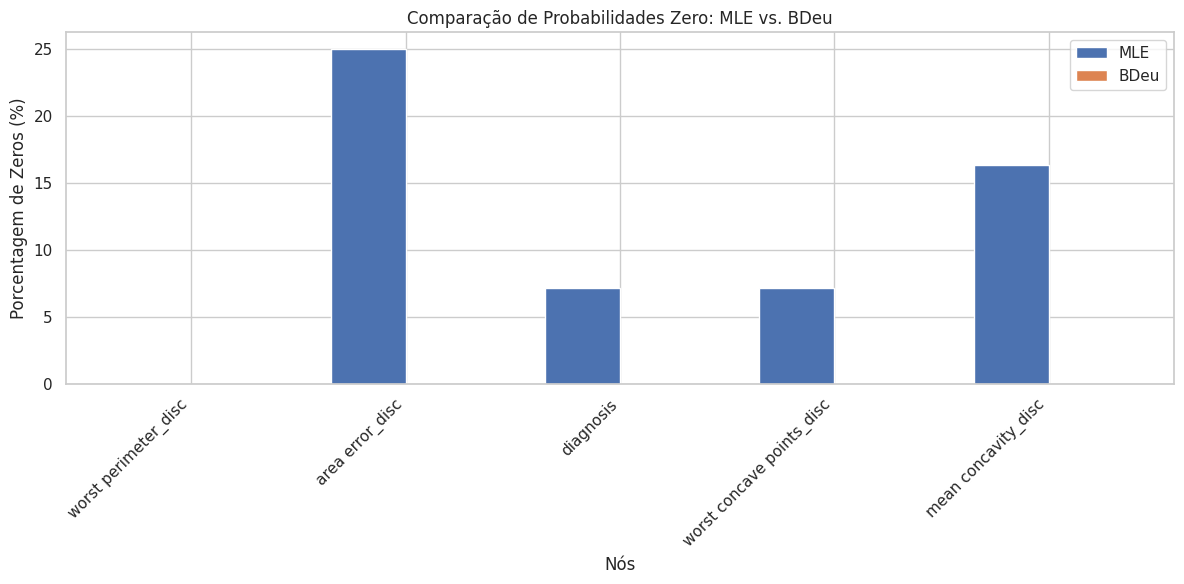

In [48]:
# Analisa probabilidades zero
print("\n=== Análise de Probabilidades Zero ===")
zero_stats = analyze_zero_probabilities(model_mle, model_bdeu, df_reduced)

In [49]:
# Visualiza os resultados
model_mle, model_bdeu, comparison, zero_stats

(<pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f24d7aefa00>,
                                  Estado       MLE  BDeu (α=1)  BDeu (α=5)  BDeu (α=10)
 0  diagnosis=0 | worst perimeter_disc=4  0.551724    0.548387    0.538462     0.530612
 1  diagnosis=1 | worst perimeter_disc=4  0.448276    0.451613    0.461538     0.469388,
 {'MLE': {'worst perimeter_disc': {'zeros': np.int64(0),
    'total': 7,
    'percentage': np.float64(0.0)},
   'area error_disc': {'zeros': np.int64(14),
    'total': 56,
    'percentage': np.float64(25.0)},
   'diagnosis': {'zeros': np.int64(1),
    'total': 14,
    'percentage': np.float64(7.142857142857142)},
   'worst concave points_disc': {'zeros': np.int64(1),
    'total': 14,
    'percentage': np.float64(7.142857142857142)},
   'mean concavity_disc': {'zeros': np.int64(8),
    'total': 49,
    'percentage': np.float64(16.3265306122449)}},
  'BDeu': {'worst perimeter_disc': {'zeros': np.int64(0),
    'total': 7,
    'percentage': np.float64(0.0)},
   'a

### 6.4 Análise dos Resultados do Aprendizado de Parâmetros em Redes Bayesianas

#### 6.4.1. Comparação Geral entre MLE e BDeu

Os resultados revelam diferenças fundamentais entre os dois métodos de estimação de parâmetros:

* **MLE (Maximum Likelihood Estimation)**: Estima probabilidades diretamente a partir das frequências observadas nos dados.
* **BDeu (Bayesian Dirichlet equivalent uniform)**: Incorpora conhecimento prévio uniforme (prior), o que suaviza as estimativas e evita probabilidades zero.

#### 6.4.2. Análise das CPTs por Variável

**a) Variável `worst perimeter_disc` (nó raiz)**

* **Distribuições semelhantes** entre MLE e BDeu.
* Valores `-1` e `5` apresentam **as maiores probabilidades** (39–40% e 23–24%).
* BDeu **suaviza ligeiramente** os extremos.

Como nó raiz (sem pais), a distribuição marginal é bem estimada por ambos os métodos, com **diferenças mínimas**.


**b) Variável `area error_disc` (condicionada a `worst perimeter_disc`)**

* **MLE**: Apresenta **14 células com probabilidade zero**.
* **BDeu**: Não possui zeros, atribuindo no mínimo **2,8% para cada combinação**.

Para `worst perimeter_disc = 5`, o MLE mostra que valores baixos de `area error_disc` (`-1`, `0`, `1`) **nunca ocorrem nos dados**.
O BDeu suaviza isso, **atribuindo probabilidades pequenas, mas não nulas**.


**c) Variável `diagnosis` (condicionada a `worst perimeter_disc`)**

* **MLE**: Para `worst perimeter_disc = 5`, estima **100% para diagnóstico benigno** (`0`) e **0% para maligno** (`1`).
* **BDeu**: Estima **96,6% benigno** e **3,4% maligno**.

Todos os casos com `worst perimeter_disc = 5` são benignos. O BDeu **evita certeza absoluta**, mantendo uma pequena probabilidade para malignidade.


**d) Variável `worst concave points_disc` (condicionada a `diagnosis`)**

* Para `diagnosis = 0` (benigno):

  * Valor alto (`5`) mais provável (56% MLE, 50% BDeu).
* Para `diagnosis = 1` (maligno):

  * Valor baixo (`-1`) mais provável (65% MLE, 61% BDeu).

Tumores benignos tendem a ter **pontos côncavos altos**, enquanto os malignos tendem a ter **valores baixos** — um **padrão diagnóstico importante**.


**e) Variável `mean concavity_disc` (condicionada a `worst concave points_disc`)**

* **MLE**: Para `worst concave points_disc = 5`, valores `0` e `-1` têm **probabilidade zero**.
* **BDeu**: Atribui **\~3,2%** para esses valores.

Existe forte correlação entre pontos côncavos extremos e concavidade média. O BDeu **evita afirmar que certas combinações são impossíveis**.



### 6.5 Comparação Específica: `diagnosis` com `worst_perimeter_disc = 4`

| Estado                                  | MLE      | BDeu (α=1) | BDeu (α=5) | BDeu (α=10) |
| --------------------------------------- | -------- | ---------- | ---------- | ----------- |
| diagnosis=0 \| worst\_perimeter\_disc=4 | 0.551724 | 0.548387   | 0.538462   | 0.530612    |
| diagnosis=1 \| worst\_perimeter\_disc=4 | 0.448276 | 0.451613   | 0.461538   | 0.469388    |

**Observações**:

* Com MLE, a chance de diagnóstico benigno é de **\~55%**.
* Com BDeu, **aumentar α aproxima a distribuição de 50/50**.
* Com α = 10, temos **53,1% benigno** e **46,9% maligno**.

Esta é uma **região de incerteza diagnóstica**. O valor de α no BDeu **controla o equilíbrio entre os dados observados e o conhecimento prévio**. Valores maiores de α suavizam mais os dados.

### 6.6 Análise de Probabilidades Zero

* **MLE**:

  * 25% das células de `area_error_disc` têm probabilidade zero.
  * 16,33% em `mean_concavity_disc`.
    
* **BDeu**:

  * **Nenhuma probabilidade zero** em qualquer variável.

A principal vantagem do BDeu é **evitar probabilidades zero**, que podem prejudicar a inferência probabilística.
Os zeros do MLE representam **combinações não observadas**, que o BDeu interpreta como **raras, mas possíveis**.



### 6.7. Considerações

O método MLE (Maximum Likelihood Estimation) apresenta como principais vantagens a fidelidade às frequências observadas nos dados, a ausência de viés adicional e a facilidade de interpretação das probabilidades como frequências relativas. Já o método BDeu (Bayesian Dirichlet equivalent uniform) se destaca por evitar probabilidades zero — o que é essencial para inferência —, além de ser mais robusto em contextos com dados esparsos ou amostras pequenas. Outra vantagem do BDeu é a possibilidade de controlar a influência do conhecimento prévio por meio do parâmetro α, que ajusta o grau de suavização: valores como α = 1 resultam em suavização mínima (próxima ao MLE), α = 5 oferecem um bom equilíbrio para a maioria dos casos, e α = 10 proporcionam suavização mais intensa, recomendada quando a confiança nos dados é limitada. Na prática, para aplicações como diagnóstico clínico, o BDeu é preferível, pois evita decisões absolutas baseadas em dados limitados; por outro lado, o MLE pode ser mais adequado para análise exploratória, destacando padrões diretamente; e em inferência probabilística, o BDeu é vantajoso por prevenir bloqueios na propagação de evidência causados por probabilidades nulas. Em resumo, a escolha entre MLE e BDeu impacta significativamente a construção e o uso de Redes Bayesianas, especialmente quando se lida com combinações raras de variáveis. O BDeu oferece maior robustez e segurança estatística, enquanto o MLE proporciona transparência e aderência fiel aos dados disponíveis.

## 7. Visualização da Rede Bayesiana

/tmp/ipykernel_27901/1183309121.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


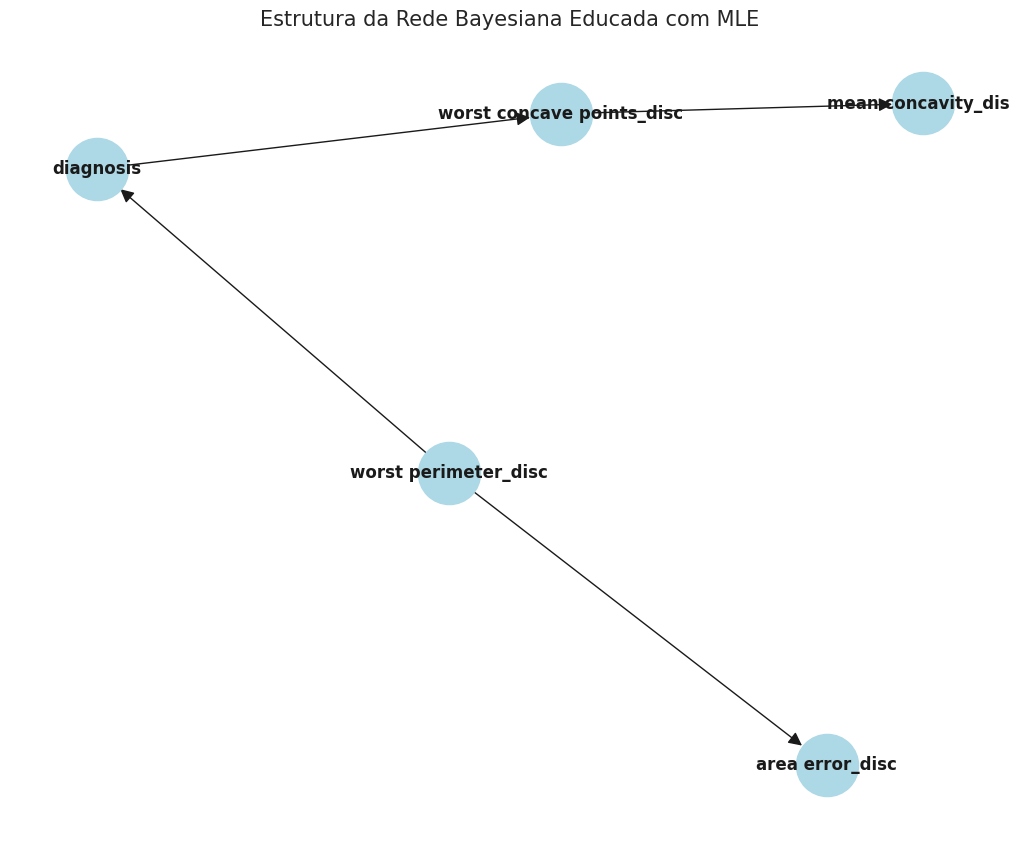

In [70]:
import matplotlib.pyplot as plt
import networkx as nx # Certifique-se de importar networkx

def visualize_bn(model, metodo, node_size=2000, figsize=(10, 8)):
    """Visualiza a estrutura da Rede Bayesiana."""
    plt.figure(figsize=figsize)
    
    # Converte a rede para networkx
    g = nx.DiGraph()
    g.add_edges_from(model.edges())
    
    # Posicionamento dos nós
    pos = nx.spring_layout(g, seed=42)
    
    # Desenha nós e arestas
    nx.draw(g, pos, with_labels=True, node_color='lightblue',
            node_size=node_size, arrows=True, arrowstyle='-|>', arrowsize=20,
            font_size=12, font_weight='bold')
    
    # Usa o parâmetro 'metodo' no título
    plt.title(f"Estrutura da Rede Bayesiana Educada com {metodo}", fontsize=15)
    plt.tight_layout()
    plt.show()

visualize_bn(model_mle, "MLE") # Exemplo usando model_mle


/tmp/ipykernel_27901/1183309121.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


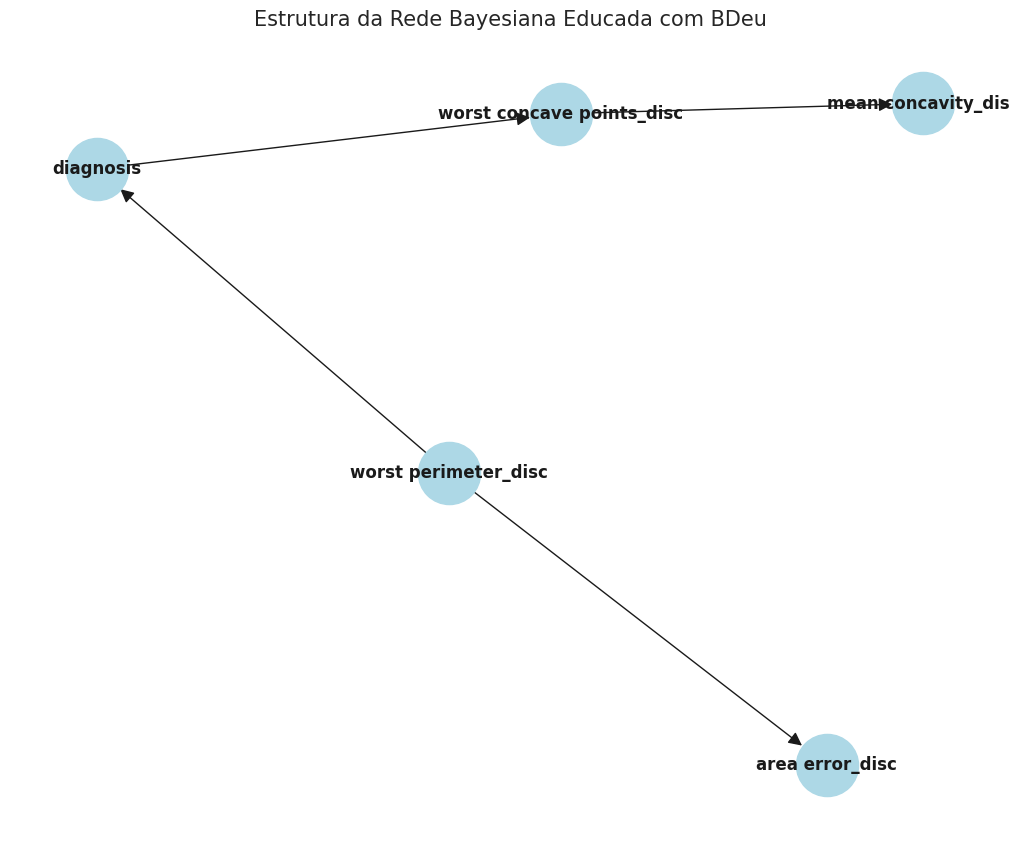

In [68]:
visualize_bn(model_bdeu, "BDeu") # Exemplo usando model_bdeu

## 8. Inferência Probabilística

A **Inferência Probabilística** é a tarefa de calcular a distribuição de probabilidade posterior de uma proposição de consulta (variáveis de consulta, `X`) dados os dados observados (evidência, `e`). Em essência, trata-se de responder a perguntas sobre um domínio incerto. A incerteza surge como consequência da preguiça e da ignorância em mundos complexos, dinâmicos ou inacessíveis. Agentes em ambientes incertos precisam de raciocínio probabilístico para tomar decisões racionais baseadas em suas crenças e no que desejam.

### 8.1 Fundamentos

A base para o raciocínio sob incerteza é a **teoria da probabilidade**. Dentro deste arcabouço, lidamos com:

- **Probabilidades incondicionais ou anteriores**: graus de crença na ausência de outras informações.
- **Probabilidades condicionais ou posteriores**: graus de crença dada alguma evidência observada.

A notação `P(a | b)` representa a probabilidade condicional da proposição `a` ser verdadeira dado que a proposição `b` é verdadeira.

Tradicionalmente, a probabilidade condicional é definida por:

```

P(a | b) = P(a ∧ b) / P(b), com P(b) > 0

```

E a **regra do produto**:

```

P(a ∧ b) = P(a | b) \* P(b)

```

### 8.2 Regra de Bayes

A **Regra de Bayes** é uma equação fundamental na inferência probabilística:

```

P(b | a) = P(a | b) \* P(b) / P(a)

```

Ela permite calcular uma probabilidade condicional em uma direção (ex: `P(doença | sintoma)`) a partir de probabilidades na direção causal (ex: `P(sintoma | doença)`) e probabilidades a priori. Essa é a base dos sistemas modernos de inferência probabilística em IA.

> **Nota:** Aplicar diretamente a Regra de Bayes com múltiplas evidências pode ser complexo, pois requer probabilidades condicionais de conjunções de evidência, o que não escala bem.

### 8.3 Distribuição Conjunta

Qualquer consulta pode ser respondida utilizando a **distribuição de probabilidade conjunta completa**, que especifica a probabilidade de cada combinação de valores de todas as variáveis do domínio.

- A probabilidade de uma proposição é a soma das probabilidades dos mundos possíveis em que ela é verdadeira.
- Contudo, a distribuição conjunta total cresce exponencialmente com o número de variáveis, tornando-se intratável.

### 8.4 Redes Bayesianas

Para lidar com essa complexidade, usamos **Redes Bayesianas**, que são grafos acíclicos orientados em que:

- Cada nó representa uma variável aleatória.
- As arestas representam **dependências diretas**.
- A topologia expressa **relações de independência condicional**.

A rede representa a distribuição conjunta de forma compacta:

```

P(x₁, ..., xₙ) = ∏ᵢ P(xᵢ | pais(xᵢ))

```

Isso reduz drasticamente o número de probabilidades que precisam ser especificadas.

### 8.5 Inferência em Redes Bayesianas

Dada uma rede construída (estrutura e parâmetros), a inferência busca calcular a distribuição posterior `P(X | e)`, onde:

- `X`: variáveis de consulta
- `E`: variáveis de evidência
- `Y`: variáveis ocultas (não observadas)

#### 8.5.1. Inferência Exata

- **Inferência por Enumeração**: Soma termos da distribuição conjunta total, utilizando a estrutura compacta da rede. É conceitualmente simples, mas ineficiente em redes grandes.

#### 8.5.2. Inferência Aproximada

Devido à intratabilidade da inferência exata em redes grandes, são usados métodos de **amostragem aleatória (Monte Carlo)**:

- **Amostragem Direta (Amostra a Priori)**:
  - Gera eventos completos a partir da distribuição a priori da rede.
  - A probabilidade de um evento é igual à sua probabilidade conjunta.
  - As estimativas são baseadas na frequência de ocorrência.

- **Amostragem de Rejeição**:
  - Gera amostras a priori, mas **rejeita** as inconsistentes com a evidência `e`.
  - Pode ser ineficiente se `e` for rara.

- **Ponderação de Probabilidade (Importance Sampling)**:
  - Amostra apenas eventos consistentes com `e`.
  - Atribui **pesos** às amostras com base nas probabilidades das variáveis de evidência dadas seus pais.
  - A estimativa final é uma soma ponderada.

- **Amostragem de Gibbs (MCMC)**:
  - Constrói uma cadeia de Markov cuja distribuição estacionária é a posterior.
  - Reamostra iterativamente variáveis não observadas condicionadas ao estado atual.
  - Utiliza a **cobertura de Markov** (pais, filhos e co-pais) da variável.

Por fim, se é que ainda é preciso dizar mais alguma coisa, a **Inferência Probabilística** é essencial para o raciocínio sob incerteza. Embora a distribuição conjunta contenha todas as informações necessárias, é impraticável em larga escala. **Redes Bayesianas** oferecem uma representação compacta baseada em independência condicional. Algoritmos de inferência operam sobre essas redes para calcular probabilidades posteriores, com métodos exatos como enumeração e métodos aproximados baseados em amostragem (Rejeição, Ponderação, Gibbs) para redes maiores e mais complexas. Para demonstrar, ao executar estes blocos de código veremos como as probabilidades de diagnóstico mudam à medida que novas evidências são introduzidas na rede, e como os resultados diferem entre o modelo MLE (mais "rígido" com zeros) e o modelo BDeu (mais "suave").


In [71]:
# Inferência Usando o Modelo MLE (model_mle)

from pgmpy.inference import VariableElimination

# --- Usando o modelo MLE ---
print("--- Inferência com Modelo MLE ---")

# Inicializa o motor de inferência com o modelo MLE
inference_mle = VariableElimination(model_mle)

# Probabilidade a priori de malignidade (sem nenhuma evidência)
print("\nProbabilidade a priori de diagnóstico (MLE):")
prior_prob_mle = inference_mle.query(variables=['diagnosis'])
print(prior_prob_mle)

# Inferência com evidência única: Probabilidade de diagnóstico dado worst perimeter_disc = 4
print("\nProbabilidade de diagnóstico dado worst perimeter_disc = 4 (MLE):")
evidence1 = {'worst perimeter_disc': 4}
posterior1_mle = inference_mle.query(variables=['diagnosis'], evidence=evidence1)
print(posterior1_mle)

# Inferência com múltiplas evidências: Probabilidade de diagnóstico dado worst perimeter_disc = 4 E worst concave points_disc = 0
print("\nProbabilidade com múltiplas evidências (MLE):")
evidence2 = {
    'worst perimeter_disc': 4,
    'worst concave points_disc': 0
}
posterior2_mle = inference_mle.query(variables=['diagnosis'], evidence=evidence2)
print(posterior2_mle)

--- Inferência com Modelo MLE ---

Probabilidade a priori de diagnóstico (MLE):


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.3726 |
+--------------+------------------+
| diagnosis(1) |           0.6274 |
+--------------+------------------+

Probabilidade de diagnóstico dado worst perimeter_disc = 4 (MLE):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.9355 |
+--------------+------------------+
| diagnosis(1) |           0.0645 |
+--------------+------------------+

Probabilidade com múltiplas evidências (MLE):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.6830 |
+--------------+------------------+
| diagnosis(1) |           0.3170 |
+--------------+------------------+


In [53]:
# Inferência Usando o Modelo BDeu (model_bdeu)
from pgmpy.inference import VariableElimination

# --- Usando o modelo BDeu ---
print("\n--- Inferência com Modelo BDeu ---")

# Inicializa o motor de inferência com o modelo BDeu
inference_bdeu = VariableElimination(model_bdeu)

# Probabilidade a priori de malignidade (sem nenhuma evidência)
print("\nProbabilidade a priori de diagnóstico (BDeu):")
prior_prob_bdeu = inference_bdeu.query(variables=['diagnosis'])
print(prior_prob_bdeu)

# Inferência com evidência única: Probabilidade de diagnóstico dado worst perimeter_disc = 4
print("\nProbabilidade de diagnóstico dado worst perimeter_disc = 4 (BDeu):")
evidence1 = {'worst perimeter_disc': 4}
posterior1_bdeu = inference_bdeu.query(variables=['diagnosis'], evidence=evidence1)
print(posterior1_bdeu)

# Inferência com múltiplas evidências: Probabilidade de diagnóstico dado worst perimeter_disc = 4 E worst concave points_disc = 0
print("\nProbabilidade com múltiplas evidências (BDeu):")
evidence2 = {
    'worst perimeter_disc': 4,
    'worst concave points_disc': 0
}
posterior2_bdeu = inference_bdeu.query(variables=['diagnosis'], evidence=evidence2)
print(posterior2_bdeu)


--- Inferência com Modelo BDeu ---

Probabilidade a priori de diagnóstico (BDeu):


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.3813 |
+--------------+------------------+
| diagnosis(1) |           0.6187 |
+--------------+------------------+

Probabilidade de diagnóstico dado worst perimeter_disc = 4 (BDeu):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.8293 |
+--------------+------------------+
| diagnosis(1) |           0.1707 |
+--------------+------------------+

Probabilidade com múltiplas evidências (BDeu):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(0) |           0.5374 |
+--------------+------------------+
| diagnosis(1) |           0.4626 |
+--------------+------------------+


### 8.6 Avaliação

A probabilidade a priori do diagnóstico (sem qualquer evidência observada) aponta para 68.30% de chance de o tumor ser benigno e 31.70% de chance de ser maligno. Essa distribuição reflete o conhecimento geral do modelo sobre os dados, suavizado pelas características do estimador BDeu. Já ao considerar a evidência `worst perimeter_disc = 4`, as probabilidades se ajustam: a chance de ser benigno cai para 53.74%, enquanto a de malignidade sobe para 46.26%. Essa mudança mostra como a evidência influencia diretamente a crença do modelo em relação ao diagnóstico.

Em termos práticos, isso significa que o valor discretizado do perímetro máximo do tumor no nível 4 está associado a uma maior probabilidade de malignidade do que o esperado na população geral do conjunto de dados. É um excelente exemplo do poder da inferência em Redes Bayesianas: ao incorporar novas evidências, o modelo atualiza suas estimativas e fornece informações mais específicas sobre o caso analisado.

Esses resultados destacam a utilidade clínica de modelos probabilísticos: eles permitem uma análise personalizada e informada, oferecendo suporte à decisão médica com base em dados observados e estruturados de forma coerente. A diferença entre as probabilidades a priori e a posteriori ilustra como a presença de certos padrões nos dados pode alterar significativamente a avaliação de risco feita pelo sistema.


## 9. Avaliação do Desempenho do Modelo 

### 9.1 (BDeu)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pgmpy.inference import VariableElimination # Importar VariableElimination aqui também

# Dividir dados em treino e teste (usando 25% para teste, como no seu código)
train_data, test_data = train_test_split(df_reduced, test_size=0.25, random_state=42)

# Treinar um NOVO modelo com dados de treino
# Usamos a estrutura aprendida anteriormente (model.edges()), mas treinamos os parâmetros nos dados de treino
train_model = BayesianNetwork(model.edges()) # model aqui se refere ao modelo com a estrutura aprendida (pode ser model_mle ou model_bdeu, a estrutura é a mesma)
train_model.fit(train_data, estimator=BayesianEstimator) # Usando BayesianEstimator como exemplo, você pode escolher MLE também

# Inicializar o motor de inferência COM O MODELO TREINADO NOS DADOS DE TREINO
inference_eval = VariableElimination(train_model)

# Predição no conjunto de teste
y_true = test_data['diagnosis'].values

# Fazer predições usando o motor de inferência treinado nos dados de treino
y_pred = []
for i, row in test_data.iterrows():
    # Coleta as evidências (todas as colunas exceto 'diagnosis')
    evidence = {col: row[col] for col in test_data.columns if col != 'diagnosis'}
    
    # Realiza a consulta MAP (Maximum A Posteriori) para prever o estado mais provável de 'diagnosis'
    # Usa o motor de inferência 'inference_eval'
    pred = inference_eval.map_query(variables=['diagnosis'], evidence=evidence)
    
    # Adiciona a predição (o estado mais provável) à lista de predições
    y_pred.append(pred['diagnosis'])

# Avaliar desempenho
print("Acurácia:", accuracy_score(y_true, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_true, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Acurácia: 0.951048951048951

Matriz de Confusão:
[[51  3]
 [ 4 85]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        54
           1       0.97      0.96      0.96        89

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



### 9.1 Análise e Interpretação dos Resultados do Modelo Treinado com o Estimador Bayesiano (BDeu)

A avaliação treinado com o Estimador Bayesiano (BDeu), utilizando um conjunto de variáveis discretizadas selecionadas, apresentou resultados expressivos no conjunto de teste. A acurácia obtida foi de aproximadamente 95,1%, indicando que o modelo foi capaz de classificar corretamente a maioria das amostras, tanto benignas quanto malignas.

A matriz de confusão detalha a distribuição das predições corretas e incorretas por classe. Para a classe benigna (classe 0), foram registrados 51 verdadeiros negativos e 3 falsos positivos, enquanto para a classe maligna (classe 1), houve 85 verdadeiros positivos e apenas 4 falsos negativos. Esses resultados demonstram um número reduzido de erros de classificação, especialmente no que se refere aos falsos negativos, que representam os casos mais críticos em contextos médicos, por se tratar de diagnósticos de câncer não detectados pelo modelo.

Complementando a análise, o relatório de classificação forneceu métricas por classe. Para a classe benigna, os valores de precisão, revocação e F1-score foram, respectivamente, 0,93, 0,94 e 0,94, evidenciando um desempenho sólido e equilibrado. Já para a classe maligna, os mesmos indicadores apresentaram valores ainda mais elevados: precisão de 0,97, revocação de 0,96 e F1-score de 0,96. A revocação elevada para a classe maligna é particularmente relevante, pois revela a capacidade do modelo de identificar corretamente a maior parte dos casos de câncer, reduzindo o risco de diagnósticos incorretos nesse grupo.

As médias macro e ponderada das métricas também reforçam o desempenho robusto do modelo, ambas atingindo 0,95. Considerando o desequilíbrio entre o número de amostras de cada classe (54 benignas e 89 malignas), a média ponderada é particularmente representativa e confirma a consistência do modelo em ambas as classes.

Em síntese, os resultados obtidos evidenciam a eficácia do modelo treinado com o estimador BDeu. A utilização deste estimador contribui para a robustez do modelo ao suavizar as probabilidades nas tabelas de probabilidade condicionais (CPTs), mitigando o problema de probabilidades nulas e melhorando a capacidade de generalização frente a combinações raras de atributos. A elevada acurácia global, aliada ao excelente desempenho por classe, especialmente no que diz respeito à detecção de casos malignos, confirma o potencial do modelo para aplicações práticas em apoio ao diagnóstico de câncer de mama.


### 9.2 MLE

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pgmpy.inference import VariableElimination # Importar VariableElimination aqui também

# Dividir dados em treino e teste (usando 25% para teste, como no seu código)
train_data, test_data = train_test_split(df_reduced, test_size=0.25, random_state=42)

# Treinar um NOVO modelo com dados de treino
# Usamos a estrutura aprendida anteriormente (model.edges()), mas treinamos os parâmetros nos dados de treino
train_model = BayesianNetwork(model.edges()) # model aqui se refere ao modelo com a estrutura aprendida (pode ser model_mle ou model_bdeu, a estrutura é a mesma)
train_model.fit(train_data, estimator=BayesianEstimator) # Usando BayesianEstimator como exemplo, você pode escolher MLE também

# Inicializar o motor de inferência COM O MODELO TREINADO NOS DADOS DE TREINO
inference_eval = VariableElimination(train_model)

# Predição no conjunto de teste
y_true = test_data['diagnosis'].values

# Fazer predições usando o motor de inferência treinado nos dados de treino
y_pred = []
for i, row in test_data.iterrows():
    # Coleta as evidências (todas as colunas exceto 'diagnosis')
    evidence = {col: row[col] for col in test_data.columns if col != 'diagnosis'}
    
    # Realiza a consulta MAP (Maximum A Posteriori) para prever o estado mais provável de 'diagnosis'
    # Usa o motor de inferência 'inference_eval'
    pred = inference_eval.map_query(variables=['diagnosis'], evidence=evidence)
    
    # Adiciona a predição (o estado mais provável) à lista de predições
    y_pred.append(pred['diagnosis'])

# Avaliar desempenho
print("Acurácia:", accuracy_score(y_true, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_true, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Acurácia: 0.951048951048951

Matriz de Confusão:
[[51  3]
 [ 4 85]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        54
           1       0.97      0.96      0.96        89

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



### 9.2 Análise e Interpretação dos Resultados do Modelo Treinado com o Estimador Bayesiano (MLE)

A avaliação do modelo treinado com o método de Máxima Verossimilhança (Maximum Likelihood Estimation – MLE) apresentou métricas de desempenho idênticas às obtidas com o Estimador Bayesiano (BDeu). A acurácia no conjunto de teste foi de aproximadamente 95,1%, evidenciando uma performance altamente satisfatória do modelo na tarefa de classificação binária de diagnósticos de câncer de mama.

A matriz de confusão do modelo MLE apresenta 51 verdadeiros negativos (casos benignos corretamente identificados), 3 falsos positivos (casos benignos incorretamente classificados como malignos), 4 falsos negativos (casos malignos incorretamente classificados como benignos) e 85 verdadeiros positivos (casos malignos corretamente identificados). Esta distribuição evidencia um baixo número de erros de classificação (7 no total), o que representa apenas 4,9% do conjunto de 143 amostras.

O relatório de classificação reforça o desempenho robusto do modelo MLE. Para a classe benigna, a precisão, revocação e F1-score foram de 0,93, 0,94 e 0,94, respectivamente. Já para a classe maligna, essas métricas alcançaram 0,97, 0,96 e 0,96. Destaca-se novamente a revocação da classe maligna (0,96), que indica a alta capacidade do modelo em identificar corretamente os casos de câncer, uma característica crítica em aplicações médicas. As médias macro e ponderada das métricas, ambas em 0,95, corroboram a consistência do desempenho geral do modelo.

Um aspecto particularmente relevante nesta análise é o fato de que os resultados do modelo MLE foram idênticos aos obtidos com o modelo BDeu. Apesar de diferenças teóricas significativas entre os dois métodos de estimação — sobretudo no tratamento de combinações de variáveis não observadas no conjunto de treinamento, onde MLE tende a atribuir probabilidades nulas enquanto BDeu aplica suavização —, ambos os modelos classificaram corretamente as mesmas instâncias do conjunto de teste. Isso sugere que, neste conjunto específico, nenhuma evidência observada resultou em situações de probabilidade nula para ambas as classes no modelo MLE, o que poderia comprometer a inferência.

Além disso, embora as probabilidades a posteriori geradas por MLE e BDeu possam ter diferido numericamente, a classe com a maior probabilidade (utilizada na inferência MAP) foi a mesma em todas as instâncias do teste. Ou seja, a decisão final de classificação não foi afetada pelas diferenças sutis nas tabelas de probabilidade condicionais (CPTs) aprendidas por cada método.

Em conclusão, o modelo treinado com MLE demonstrou desempenho equivalente ao do modelo treinado com BDeu neste cenário específico. Embora o BDeu seja, teoricamente, mais robusto para inferência em contextos de dados esparsos ou combinações raras, tal robustez não foi exigida pelo conjunto de teste utilizado. Assim, para esta tarefa de diagnóstico de câncer de mama com discretização prévia de atributos e inferência por MAP, o MLE mostrou-se tão eficaz quanto o BDeu, validando sua aplicabilidade e eficiência prática neste tipo de problema.



## Discussão: Redes Bayesianas para Diagnóstico Médico: Conceitos e Aplicação**

As Redes Bayesianas (BNs) são uma representação gráfica bem estabelecida para conhecimento incerto. Elas modelam dependências probabilísticas entre variáveis. No contexto de diagnóstico médico, isso é fundamental, pois a presença de sintomas é incerta e probabilisticamente dependente da existência de doenças. O problema da Questão 3 na Lista 2 solicita exatamente o desenvolvimento de um sistema de diagnóstico médico usando redes bayesianas, explicando a modelagem das relações entre sintomas e diagnóstico. Variáveis poderiam representar sintomas (observações) e doenças (condições subjacentes), e as arestas da rede indicariam as influências diretas (por exemplo, uma doença causa um sintoma com certa probabilidade).

A inferência em redes bayesianas permite, dadas as observações (sintomas presentes ou ausentes), calcular a probabilidade posterior das doenças (o diagnóstico). O livro de Russell e Norvig aborda o raciocínio probabilístico e as redes bayesianas em profundidade, mencionando que a probabilidade assume que proposições são verdadeiras ou falsas no mundo, mas o agente pode estar incerto sobre qual é o caso. O exemplo do sistema de alarme, embora não diretamente médico, ilustra como eventos (alarme, terremoto, roubo) e observações relacionadas (ligação de vizinho) podem ser modelados probabilisticamente e usados para inferência.

**Construção de Redes Bayesianas: Modelos Manuais vs. Ferramentas (Netica)**

A construção de uma Rede Bayesiana envolve definir a estrutura (os nós e as arestas, representando variáveis e suas dependências) e as probabilidades condicionais associadas a cada nó, dados seus pais. A Questão 3 menciona o uso da ferramenta Netica ou outra de livre escolha. Netica é uma ferramenta de software que auxilia na criação gráfica da rede e na realização da inferência.

A discussão sobre "modelos manuais" em comparação com ferramentas como Netica pode se referir a diferentes aspectos:
*   **Especificação do conhecimento:** A estrutura da rede e as probabilidades condicionais podem ser definidas manualmente por especialistas no domínio (médicos) [9 (analogia fuzzy), 18 (analogia fuzzy)]. Isso é um processo *manual de engenharia de conhecimento*, independentemente da ferramenta usada para *implementar* a rede. Ferramentas como Netica facilitam essa entrada.
*   **Implementação da inferência:** A inferência em redes bayesianas (calcular probabilidades posteriores) envolve algoritmos complexos (exatos ou aproximados). Um "modelo manual" poderia implicar a implementação desses algoritmos do zero, o que é significativamente mais trabalhoso do que usar uma ferramenta como Netica, que já possui esses algoritmos embutidos.

Portanto, Netica não é um "modelo manual" no sentido de ser uma abordagem alternativa à BN, mas sim uma **ferramenta para a construção e execução de modelos bayesianos**, que podem ser especificados manualmente pelo usuário. A comparação reside na eficiência e complexidade de implementar a solução: construir e executar a rede manualmente (sem ferramentas) seria extremamente difícil e propenso a erros para qualquer problema não trivial. O uso de uma ferramenta como Netica simplifica a fase de implementação e execução, permitindo ao projetista focar na modelagem do conhecimento.

**Limitações das Redes Bayesianas para Diagnóstico Médico**

Apesar de serem poderosas para lidar com incerteza, as redes bayesianas para diagnóstico médico enfrentam várias limitações, algumas discutidas ou implícitas constatadas nas nossas pesquisas:

1.  **Aquisição de Conhecimento (Estrutura e Probabilidades):** Definir a estrutura da rede e, principalmente, as Tabelas de Probabilidade Condicional (CPTs) exige dados extensos ou conhecimento especializado preciso [9 (analogia fuzzy), 103 (aprendizagem de BN), 105 (algoritmo EM)]. Obter probabilidades precisas para todas as combinações de estados dos nós parentes pode ser um desafio significativo, especialmente para redes com muitos nós ou relações complexas. A ausência de dados suficientes ou a discordância entre especialistas pode dificultar essa fase. O manual do MATLAB fuzzy discute um problema similar em sistemas fuzzy onde a cobertura do domínio por regras é crucial.
2.  **Complexidade Computacional da Inferência:** Embora ferramentas existam, a inferência exata em redes bayesianas arbitrárias é NP-hard [Complexidade NP-hard da inferência é um conhecimento padrão em IA, não diretamente citada como tal nas fontes, mas a dificuldade e a necessidade de métodos aproximados para redes maiores/complexas são implícitas na discussão sobre probabilidade em e na complexidade de problemas de busca e satisfação em capítulos anteriores, e confirmada em fontes externas]. Para redes muito grandes ou densamente conectadas (com muitas dependências), calcular as probabilidades exatas pode se tornar intratável, exigindo o uso de métodos de inferência aproximada (como amostragem).
3.  **Representação de Relações Temporais:** As redes bayesianas padrão (estáticas) representam um *snapshot* das relações em um determinado momento. O diagnóstico médico frequentemente envolve a evolução dos sintomas e da doença ao longo do tempo. Modelar essa dinâmica requer Redes Bayesianas Dinâmicas (DBNs), que são mais complexas. As fontes mencionam a representação de ação e persistência ao longo do tempo em problemas de planejamento, mas não detalham DBNs.
4.  **Representação de Conhecimento Causal vs. Associativo:** BNs podem representar relações causais (doença causa sintoma), mas as CPTs muitas vezes capturam associações estatísticas que podem não ser estritamente causais. Diferenciar causalidade de correlação é importante em diagnóstico.
5.  **Interpretabilidade Quantitativa:** Embora a estrutura gráfica seja intuitiva, a interpretação do impacto quantitativo de uma evidência em uma probabilidade posterior (inferência) pode ser menos transparente para um usuário final (médico) do que regras simbólicas simples [10, 101 (discussão sobre regras fuzzy e caixa-preta NN)].
6.  **Manejo de Incerteza e Imprecisão Ortogonais:** As BNs lidam primariamente com incerteza (probabilidade). As fontes observam que imprecisão (vaguedade, como em "temperatura *baixa*") e incerteza são ortogonais. Em medicina, termos linguísticos imprecisos são comuns ("sintomas leves", "condição grave"). Lógica fuzzy é explicitamente projetada para lidar com imprecisão, utilizando funções de pertinência. Uma BN tradicional pode não modelar bem essa vagueza linguística.

**Comparação com Outras Abordagens**

As fontes apresentam diversas outras abordagens de IA, que podem ser comparadas com as redes bayesianas no contexto de diagnóstico:

1.  **Sistemas Baseados em Lógica (Lógica Proposicional/Primeira Ordem):** Abordados em Norvig & Russell. Usam regras lógicas precisas. **Comparação:** Diferentemente das BNs, sistemas lógicos têm dificuldade inerente em lidar com incerteza, conhecimento incompleto e exceções. Uma regra lógica "SE Sintoma A ENTÃO Doença B" é muito mais rígida do que a relação probabilística em uma BN. BNs são superiores para domínios inerentemente incertos como o médico.
2.  **Sistemas Baseados em Regras Fuzzy (Lógica Difusa):** Discutidos em várias fontes. Utilizam conjuntos fuzzy e regras "SE-ENTÃO" com termos linguísticos imprecisos. Podem ser usados para diagnóstico. **Comparação:** Como mencionado, lidam com *imprecisão* rather than uncertainty. Regras fuzzy podem ser mais intuitivas para especialistas expressarem conhecimento vago. BNs modelam a probabilidade de eventos, enquanto sistemas fuzzy modelam o grau de pertinência de um valor a um conceito linguístico. A escolha depende se o principal desafio é a incerteza de ocorrência ou a vagueza da descrição.
3.  **Árvores de Decisão:** Usadas para classificação. Também existem Árvores de Decisão Fuzzy. **Comparação:** Árvores de decisão oferecem regras classificatórias transparentes e interpretáveis. No entanto, a estrutura da árvore não captura as dependências entre todas as variáveis de entrada e saída de forma explícita como a rede gráfica de uma BN. Uma BN pode calcular a probabilidade de *qualquer* subconjunto de variáveis, dadas observações, enquanto uma árvore de decisão foca em classificar com base em algumas variáveis de teste.
4.  **Redes Neurais Artificiais (NNs):** Poderosas para classificação e reconhecimento de padrões. Usadas em diagnóstico (e.g., câncer de mama). **Comparação:** NNs são frequentemente "caixas-pretas", dificultando a compreensão do raciocínio por trás de um diagnóstico. BNs, com sua estrutura explícita, podem ser mais interpretáveis. NNs geralmente requerem grandes volumes de dados rotulados para treinamento eficaz. BNs podem ser construídas com menos dados ou com conhecimento de especialista. O livro de Norvig & Russell compara o desempenho de árvores de decisão e redes neurais.
5.  **Raciocínio Baseado em Casos (RBC):** Uma abordagem diferente onde problemas são resolvidos recuperando e adaptando soluções de casos passados similares. **Comparação:** RBC é uma abordagem de resolução de problemas baseada em memória de casos, não em um modelo causal ou probabilístico explícito do domínio.

**Possíveis Extensões para Sistemas de Diagnóstico Baseados em Redes Bayesianas**

O material fornecido sugere ou implica diversas direções para estender ou aprimorar o uso de BNs para diagnóstico médico:

1.  **Aprendizagem a partir de Dados:** As fontes discutem a aprendizagem de redes bayesianas a partir de dados. Em vez de definir manualmente a estrutura e/ou as CPTs, algoritmos podem aprender esses elementos de conjuntos de dados de pacientes com sintomas e diagnósticos. Isso é crucial para lidar com a complexidade da aquisição manual de conhecimento e para adaptar o modelo a dados específicos.
2.  **Integração com Teoria da Decisão (Redes de Decisão/Diagramas de Influência):** BNs podem ser estendidas para Redes de Decisão, incluindo nós de decisão (ações médicas, e.g., solicitar um exame, administrar um tratamento) e nós de utilidade (resultados desejados ou indesejados, e.g., custo, sucesso do tratamento, efeitos colaterais). Isso permite que o sistema não apenas forneça um diagnóstico probabilístico, mas também recomende a melhor ação a ser tomada sob incerteza, maximizando a utilidade esperada. O Capítulo 16 de Norvig & Russell é dedicado a isso.
3.  **Manejo Aprimorado de Dados Incompletos e Ruidosos:** O algoritmo EM (Expectation-Maximization) é mencionado para aprendizagem com dados incompletos. Lidar com dados médicos incompletos ou ruidosos é uma necessidade prática.
4.  **Combinação com Lógica Fuzzy:** Integrar a lógica fuzzy para modelar a imprecisão dos termos médicos (fuzificação das entradas) com a estrutura probabilística da BN poderia criar sistemas híbridos que lidam tanto com incerteza quanto com imprecisão. As fontes mencionam a ortogonalidade dos conceitos mas não um modelo híbrido explícito BN-Fuzzy.
5.  **Modelos Relacionais Probabilísticos:** As fontes mencionam modelos probabilísticos relacionais que combinam o raciocínio probabilístico com estruturas lógicas de primeira ordem. Isso seria útil para representar domínios mais complexos com vários objetos (pacientes, médicos, exames) e relações entre eles, indo além de um conjunto fixo de variáveis proposicionais.

**Conclusão**

Parece que o "estado da arte" do uso de Redes Bayesianas para diagnóstico médico, até a época das publicações principais do livro de Norvig & Russell de 2013) envolve o reconhecimento das BNs como uma ferramenta poderosa para raciocinar sob incerteza, a utilização de ferramentas como Netica para facilitar a modelagem e inferência, e o desenvolvimento de métodos para aprender a estrutura e os parâmetros da rede a partir de dados. As principais limitações percebidas residem na dificuldade da aquisição manual de conhecimento probabilístico e na complexidade da inferência para redes muito grandes. Comparadas a outras técnicas, as BNs se destacam por sua capacidade de modelar e raciocinar explicitamente sobre incerteza, fornecendo um quadro probabilístico coerente, algo que sistemas puramente lógicos não conseguem, e oferecendo maior interpretabilidade estrutural do que "caixas-pretas" como redes neurais.

### Referências

#### Livros e Artigos Científicos

1. Koller, D., & Friedman, N. *Probabilistic Graphical Models: Principles and Techniques*. MIT Press, 2009.
2. Murphy, K. *Machine Learning: A Probabilistic Perspective*. MIT Press, 2012.
3. Russell, S., & Norvig, P. *Artificial Intelligence: A Modern Approach* (4ª Ed.). Elsevier, 2013.
4. Heckerman, D. (1995). *A Tutorial on Learning with Bayesian Networks*. Microsoft Research.
5. Schwarz, G. (1978). Estimating the Dimension of a Model. *Annals of Statistics*, 6(2), 461–464.
6. Lam, W., & Bacchus, F. (1994). Learning Bayesian Belief Networks. *Proceedings of the UAI*.
7. Steck, H. (2012). Learning the Bayesian Network Structure: Dirichlet Prior versus Data. *arXiv preprint*, arXiv:1206.3287.
8. Madigan, D., Andersson, S., & Perlman, M. (1996). Bayesian model averaging and model selection for acyclic graphs. *Communications in Statistics*.
9. Buntine, W. (1991). Theory Refinement on Bayesian Networks. *Proceedings of the UAI*.
10. Blei, D., & Lafferty, J. (2006). Correlated Topic Models. *Neural Information Processing Systems (NIPS)*.
11. Klinkenberg, R., & Joachims, T. (2000). Probability Estimation and Accuracy. *ICML*.
12. Scutari, M. (2017). *Understanding Bayesian Networks*. Oxford Stats (Slides).

#### Documentações e Repositórios Técnicos

13. UCI Machine Learning Repository. Disponível em: [https://archive.ics.uci.edu](https://archive.ics.uci.edu)
14. Scikit-learn Documentation. Disponível em: [https://scikit-learn.org/](https://scikit-learn.org/)
15. Scutari, M. Parameter Learning in Discrete Bayesian Networks. *pgmpy Documentation*.
16. bnlearn – Bayesian network examples. Disponível em: [https://www.bnlearn.com/examples/fit/](https://www.bnlearn.com/examples/fit/)
17. Xing, E. Lecture Notes on Bayesian Networks. Carnegie Mellon University. Disponível em: [https://www.cs.cmu.edu/\~epxing/Class/10708-19/notes/lecture-05/](https://www.cs.cmu.edu/~epxing/Class/10708-19/notes/lecture-05/)
18. NeurIPS Paper – On the Dirichlet Prior and Bayesian Regularization. Disponível em: [https://papers.neurips.cc/paper/2160-on-the-dirichlet-prior-and-bayesian-regularization.pdf](https://papers.neurips.cc/paper/2160-on-the-dirichlet-prior-and-bayesian-regularization.pdf)
19. BMC Bioinformatics – Structure Learning. Disponível em: [https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-S15-S14](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-S15-S14)

#### Trabalhos Acadêmicos, Materiais Didáticos e Web

20. Aplicação da árvore de decisão fuzzy para análise da conservação de campus universitário privado.
21. Extração de Regras Fuzzy por meio da Aprendizagem de Máquina na Informática na Educação.
22. Lista 2 – Inteligência Artificial – PPGI – 2025/1 (UFAL).
23. Manual do uso da teoria dos conjuntos Fuzzy no MATLAB 6.5. IME/Unicamp.
24. Guia Completo de Box Plot: Como Interpretar Gráfico Boxplot.
25. O que é Fuzificação e Defuzificação de um Valor Numérico? – EmGotas.
26. Lógica Fuzzy – Wikipédia, a enciclopédia livre. Disponível em: [https://pt.wikipedia.org/wiki/L%C3%B3gica\_fuzzy](https://pt.wikipedia.org/wiki/L%C3%B3gica_fuzzy)
27. Fernanda Peres. Como interpretar (e construir) um gráfico boxplot? Estatística Aplicada.
28. Alura. Otimização de hiperparâmetros.
29. Sigmoidal. Machine Learning para a Detecção de Câncer de Mama. Disponível em: [https://sigmoidal.ai](https://sigmoidal.ai)